## Install and import

Need Python version between 3.8-3.11 for tensorflow==2.13

Note: used miniconda for package management

In [1]:
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]


Install packages

In [2]:
pip install -r Requirements.txt

  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.stattools (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa.stattools
Note: you may need to restart the kernel to use updated packages.


Import libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json
import datetime as dt
import requests
import os
from fredapi import Fred
import tensorflow as tf
from bs4 import BeautifulSoup
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score

2025-04-25 23:12:07.067698: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 23:12:07.088853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 23:12:07.434738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## S&P500 data extract and clean

Create a date range. This date range has been set to 1950-present because volume data is missing before 1950.

In [4]:
end_date = dt.datetime.now()
start_date = dt.datetime(1950, 1, 1)

Pull S&P500 data using API from rapidapi.com

In [5]:
url = "https://s-p-500-history-api.p.rapidapi.com/historical-stock-data.php"

querystring = {"interval":"day","symbol":"^GSPC","start":start_date,"end":end_date}

headers = {
	"x-rapidapi-key": "1818711435msh7ff1e71cfe61ec4p1b64e1jsn32c289b7a487",
	"x-rapidapi-host": "s-p-500-history-api.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)


Extract data from json file. Daily and weekly timeframes. My API monthly data only went back to 1985.

In [6]:
response_json = json.loads(response.text)
sp = pd.DataFrame(response_json['data'])
sp.head()

querystring = {"interval":"week","symbol":"^GSPC","start":start_date,"end":end_date}
response = requests.get(url, headers=headers, params=querystring)
response_json = json.loads(response.text)
sp_weekly = pd.DataFrame(response_json['data'])
sp_weekly.head()

,date_time,timestamp,high,low,close,open,volume,adjusted_close
0,"January 1, 1950, 5:00 AM UTC",-631134000,17.090000,16.660000,17.090000,16.660000,9040000,17.090000
1,"January 8, 1950, 5:00 AM UTC",-630529200,17.090000,16.650000,16.650000,17.080000,14790000,16.650000
2,"January 15, 1950, 5:00 AM UTC",-629924400,16.940001,16.719999,16.940001,16.719999,7980000,16.940001
3,"January 22, 1950, 5:00 AM UTC",-629319600,16.920000,16.730000,16.900000,16.920000,7430000,16.900000
4,"January 29, 1950, 5:00 AM UTC",-628714800,17.350000,17.020000,17.350000,17.020000,10120000,17.350000


Edit 'date_time' field in sp and sp_weekly to datetime dtype

In [7]:
sp['date_time'].info

<bound method Series.info of 0        January 3, 1950, 2:30 PM UTC
1        January 4, 1950, 2:30 PM UTC
2        January 5, 1950, 2:30 PM UTC
3        January 6, 1950, 2:30 PM UTC
4        January 9, 1950, 2:30 PM UTC
                     ...             
18944     April 21, 2025, 1:30 PM UTC
18945     April 22, 2025, 1:30 PM UTC
18946     April 23, 2025, 1:30 PM UTC
18947     April 24, 2025, 1:30 PM UTC
18948     April 25, 2025, 1:30 PM UTC
Name: date_time, Length: 18949, dtype: object>

In [8]:
sp_weekly['date_time'] = pd.to_datetime(sp_weekly['date_time'])
sp['date_time'] = pd.to_datetime(sp['date_time'])

/tmp/ipykernel_86179/4117627709.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp['date_time'] = pd.to_datetime(sp['date_time'])


In [9]:
sp['date_time'].info

<bound method Series.info of 0       1950-01-03 14:30:00+00:00
1       1950-01-04 14:30:00+00:00
2       1950-01-05 14:30:00+00:00
3       1950-01-06 14:30:00+00:00
4       1950-01-09 14:30:00+00:00
                   ...           
18944   2025-04-21 13:30:00+00:00
18945   2025-04-22 13:30:00+00:00
18946   2025-04-23 13:30:00+00:00
18947   2025-04-24 13:30:00+00:00
18948   2025-04-25 13:30:00+00:00
Name: date_time, Length: 18949, dtype: datetime64[ns, UTC]>

Drop 'timestamp' and 'adjusted close' columns

In [10]:
sp.drop(columns=['timestamp','adjusted_close'], inplace=True, axis=1)

sp_weekly.drop(columns=['timestamp','adjusted_close'], inplace=True, axis=1)

## Collect macroeconomic FRED data

Extract urls from 'FRED Data URLs.json' (exported file of FRED webpages I am going to pull from) using 'cntrl+shift+L' in VSCode

Note: DFF is daily and will be added later

In [11]:

url_list = [
"https://fred.stlouisfed.org/series/PAYEMS",
"https://fred.stlouisfed.org/series/INDPRO",
"https://fred.stlouisfed.org/series/CE16OV",
"https://fred.stlouisfed.org/series/UNRATE",
"https://fred.stlouisfed.org/series/GDP",
"https://fred.stlouisfed.org/series/A191RP1Q027SBEA",
"https://fred.stlouisfed.org/series/CPIAUCSL",
"https://fred.stlouisfed.org/series/SAHMCURRENT",
"https://fred.stlouisfed.org/series/LORSGPORUSQ659S",
"https://fred.stlouisfed.org/series/BOGZ1FL135010005Q",
"https://fred.stlouisfed.org/series/UMCSENT",
"https://fred.stlouisfed.org/series/HOUST",
"https://fred.stlouisfed.org/series/W875RX1#0##0",
"https://fred.stlouisfed.org/series/M2SL",
"https://fred.stlouisfed.org/series/PRS85006091",
"https://fred.stlouisfed.org/series/DFF",
"https://fred.stlouisfed.org/series/SHTSAUS",
"https://fred.stlouisfed.org/series/M1V",
"https://fred.stlouisfed.org/series/M2V",
"https://fred.stlouisfed.org/series/INTDSRUSM193N",
"https://fred.stlouisfed.org/series/USREC"
]


Use BeautifulSoup to extract metadata from above urls. Create a dictionary and lists of those values.

In [12]:


fred_dictionary = {}
title_list = []
notes_list = []
id_list = []
frequency_list = []

# Loop through the URLs and extract the title and paragraph under "Notes"
for url in url_list:
# Extract the title 
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    title = soup.title.string.strip()
    title_list.append(title)
# Extract the paragraph under "Notes"
    notes = soup.find("div", id="notes") 
    notes_text = notes.get_text(strip=True)
    notes_list.append(notes_text) 
# Extract the "Frequency"
    frequency = soup.find("span", class_="series-meta-value-frequency")
    frequency_text = frequency.get_text(strip=True)
    frequency_list.append(frequency_text) 
# Extract the ID values from () in the title
    pipe = title.find("|")
    left_of_pipe = title[:pipe]
    id = left_of_pipe[left_of_pipe.rfind("("):]
    id = id.replace("(", "")
    id = id.replace(")", "")
    id_text = id.strip() 
    id_list.append(id_text)

# Create a dictionary with the extracted data
    fred_dictionary[id_text] = {
        "url": url,
        "id": id_text,
        "title": title,
        "frequency": frequency_text,
        "notes": notes_text
    }

# Print the extracted data
    print(f"URL: {url}")
    print(f"ID: {id_text}")
    print(f"Title: {title}") 
    print(f"Frequency: {frequency_text}") 
    print(f"Notes: {notes_text}\n")


URL: https://fred.stlouisfed.org/series/PAYEMS
ID: PAYEMS
Title: All Employees, Total Nonfarm (PAYEMS) | FRED | St. Louis Fed
Frequency: Monthly
Notes: NotesSource:U.S. Bureau of Labor StatisticsRelease:Employment SituationUnits:Thousands of Persons, Seasonally AdjustedFrequency:MonthlyNotes:All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).This measure provides useful insights into the current economic situation because it can represent the number of jobs added or lost in an economy. Increases in employment might indicate that businesses are hiring which might also suggest that businesses are growing. Additionally, those who are newly employed have increased their perso

Use the FRED API library and use a key to access series. Make a dictionary out of those series.

In [13]:
# FRED API
fred_api_key = Fred(api_key='9de274aca217f6c8787ddb88fbcf323c')

df_dict = {}

for df_name in id_list:
    fred_series = fred_api_key.get_series(df_name, start_date, end_date)
    df_dict[df_name] = pd.DataFrame(fred_series, columns=[df_name])
df_dict

{'PAYEMS':               PAYEMS
 1950-01-01   43526.0
 1950-02-01   43297.0
 1950-03-01   43954.0
 1950-04-01   44382.0
 1950-05-01   44718.0
 ...              ...
 2024-11-01  158619.0
 2024-12-01  158942.0
 2025-01-01  159053.0
 2025-02-01  159170.0
 2025-03-01  159398.0
 
 [903 rows x 1 columns],
 'INDPRO':               INDPRO
 1950-01-01   14.0049
 1950-02-01   14.0586
 1950-03-01   14.5156
 1950-04-01   14.9995
 1950-05-01   15.3489
 ...              ...
 2024-11-01  101.9619
 2024-12-01  103.1177
 2025-01-01  103.3418
 2025-02-01  104.2202
 2025-03-01  103.8892
 
 [903 rows x 1 columns],
 'CE16OV':               CE16OV
 1950-01-01   57635.0
 1950-02-01   57751.0
 1950-03-01   57728.0
 1950-04-01   58583.0
 1950-05-01   58649.0
 ...              ...
 2024-11-01  161183.0
 2024-12-01  161661.0
 2025-01-01  163895.0
 2025-02-01  163307.0
 2025-03-01  163508.0
 
 [903 rows x 1 columns],
 'UNRATE':             UNRATE
 1950-01-01     6.5
 1950-02-01     6.4
 1950-03-01     6.3
 1950-0

## Clean FRED DataFrame Dictionary

Make a copy of the df_dict

In [14]:
df_dict_copy = df_dict.copy()

Check the columns of dataframes in dictionary  

In [15]:
for key, value in df_dict_copy.items():
    print(f"{key}: {value.columns}")

PAYEMS: Index(['PAYEMS'], dtype='object')
INDPRO: Index(['INDPRO'], dtype='object')
CE16OV: Index(['CE16OV'], dtype='object')
UNRATE: Index(['UNRATE'], dtype='object')
GDP: Index(['GDP'], dtype='object')
A191RP1Q027SBEA: Index(['A191RP1Q027SBEA'], dtype='object')
CPIAUCSL: Index(['CPIAUCSL'], dtype='object')
SAHMCURRENT: Index(['SAHMCURRENT'], dtype='object')
LORSGPORUSQ659S: Index(['LORSGPORUSQ659S'], dtype='object')
BOGZ1FL135010005Q: Index(['BOGZ1FL135010005Q'], dtype='object')
UMCSENT: Index(['UMCSENT'], dtype='object')
HOUST: Index(['HOUST'], dtype='object')
W875RX1: Index(['W875RX1'], dtype='object')
M2SL: Index(['M2SL'], dtype='object')
PRS85006091: Index(['PRS85006091'], dtype='object')
DFF: Index(['DFF'], dtype='object')
SHTSAUS: Index(['SHTSAUS'], dtype='object')
M1V: Index(['M1V'], dtype='object')
M2V: Index(['M2V'], dtype='object')
INTDSRUSM193N: Index(['INTDSRUSM193N'], dtype='object')
USREC: Index(['USREC'], dtype='object')


Loop through to rename the first column to 'date' and set is as datetime

In [16]:
for key, value in df_dict_copy.items():
    df_dict_copy[key] = df_dict_copy[key].reset_index()
    df_dict_copy[key].rename(columns={"index": "date"}, inplace=True) 
    df_dict_copy[key]['date'] = pd.to_datetime(df_dict_copy[key]['date']) 
    df_dict_copy[key].set_index('date', inplace=True)



Look for NAs

In [17]:
for key, value in df_dict_copy.items():
    if value.isna().sum().sum() > 0:
        print(f"{key}: {value.isna().sum()}")


BOGZ1FL135010005Q: BOGZ1FL135010005Q    6
dtype: int64
UMCSENT: UMCSENT    210
dtype: int64


In [18]:
print(df_dict_copy['BOGZ1FL135010005Q'][df_dict_copy['BOGZ1FL135010005Q'].isna().any(axis=1)])

print(df_dict_copy['UMCSENT'][df_dict_copy['UMCSENT'].isna().any(axis=1)])

            BOGZ1FL135010005Q
date                         
1950-01-01                NaN
1950-04-01                NaN
1950-07-01                NaN
1951-01-01                NaN
1951-04-01                NaN
1951-07-01                NaN
            UMCSENT
date               
1952-12-01      NaN
1953-01-01      NaN
1953-03-01      NaN
1953-04-01      NaN
1953-05-01      NaN
...             ...
1977-06-01      NaN
1977-07-01      NaN
1977-09-01      NaN
1977-10-01      NaN
1977-12-01      NaN

[210 rows x 1 columns]


Drop UMCSENT from dictionary and clean the BOGZ1FL135010005Q dataframe

In [19]:
df_dict_copy['BOGZ1FL135010005Q'].dropna(inplace=True)
df_dict_copy.pop('UMCSENT')

# Drop the first row of the DataFrame
df_dict_copy['BOGZ1FL135010005Q'] = df_dict_copy['BOGZ1FL135010005Q'].iloc[1:]

df_dict_copy['BOGZ1FL135010005Q'].head()

,BOGZ1FL135010005Q
date,
1951-10-01,66460.0
1952-01-01,66604.0
1952-04-01,66759.0
1952-07-01,66934.0
1952-10-01,67027.0


Identify all monthly datasets and quarterly datasets

In [20]:
for key, value in fred_dictionary.items():
    print(f"{key}: {value['frequency']}")




PAYEMS: Monthly
INDPRO: Monthly
CE16OV: Monthly
UNRATE: Monthly
GDP: Quarterly
A191RP1Q027SBEA: Quarterly
CPIAUCSL: Monthly
SAHMCURRENT: Monthly
LORSGPORUSQ659S: Quarterly
BOGZ1FL135010005Q: Quarterly
UMCSENT: Monthly
HOUST: Monthly
W875RX1: Monthly
M2SL: Monthly
PRS85006091: Quarterly
DFF: Daily,7-Day
SHTSAUS: Monthly
M1V: Quarterly
M2V: Quarterly
INTDSRUSM193N: Monthly
USREC: Monthly


Review DFF

In [21]:
df_dict_copy['DFF'].head()
#This is all good and will be added as daily

,DFF
date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


Separate them into new monthly and quarterly dictionaries

In [22]:
monthly_dfs = {}
quarterly_dfs = {}

# Use the key to look up the frequency in fred_dictionary
for key, value in df_dict_copy.items():
    if fred_dictionary[key]['frequency'] == "Monthly":
        monthly_dfs[key] = value
    elif fred_dictionary[key]['frequency'] == "Quarterly":
        quarterly_dfs[key] = value

In [23]:
monthly_dfs['HOUST'].head()

,HOUST
date,
1959-01-01,1657.0
1959-02-01,1667.0
1959-03-01,1620.0
1959-04-01,1590.0
1959-05-01,1498.0


I realized that these monthly and quarterly datasets need to be lagged by 1 month or quarter. Drop na to account for na created at the end of the DF. Please see below

In [24]:
for key, df in monthly_dfs.items():
    monthly_dfs[key] = df.shift(1)
    monthly_dfs[key].dropna(inplace=True)


for key, df in quarterly_dfs.items():
    quarterly_dfs[key] = df.shift(1)
    quarterly_dfs[key].dropna(inplace=True) 


I will remove USREC because this data is released with an inconsistent lag.

In [25]:
# Drop USREC from monthly_dfs
monthly_dfs.pop('USREC', None)

,USREC
date,
1950-02-01,0.0
1950-03-01,0.0
1950-04-01,0.0
1950-05-01,0.0
1950-06-01,0.0
...,...
2024-11-01,0.0
2024-12-01,0.0
2025-01-01,0.0


Edit the weekly data to lag by 1 week.

In [26]:

for col in sp_weekly.columns:
    sp_weekly[col] = sp_weekly[col].shift(1)
    sp_weekly.dropna(inplace=True)


Edit the daily data to lag by 1 day.

In [27]:

for col in sp.columns:
    sp[col] = sp[col].shift(1)
    sp.dropna(inplace=True)

df_dict_copy['DFF'] = df_dict_copy['DFF'].shift(1)
df_dict_copy['DFF'].dropna(inplace=True)

## Convert monthly and quarterly dictionaries into two DataFrames, then combine into single daily DataFrame

Create dataframes for monthly and quarterly, then combine dataframes in dictionaries

In [28]:
combined_monthly_dfs = pd.concat(monthly_dfs.values(), axis=1)

combined_quarterly_dfs = pd.concat(quarterly_dfs.values(), axis=1)

Review NAs to see which dates are missing from which feature. I've commented out the max_rows option because it was slowing down my system and I only needed to look at all values once.

In [29]:
# pd.set_option('display.max_rows', None)

combined_quarterly_dfs[combined_quarterly_dfs.isna().any(axis=1)]
combined_monthly_dfs[combined_monthly_dfs.isna().any(axis=1)]

,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,INTDSRUSM193N
date,,,,,,,,,,,
1950-02-01,43526.0,14.0049,57635.0,6.5,23.510,2.47,NaN,NaN,NaN,NaN,1.5
1950-03-01,43297.0,14.0586,57751.0,6.4,23.610,2.17,NaN,NaN,NaN,NaN,1.5
1950-04-01,43954.0,14.5156,57728.0,6.3,23.640,1.73,NaN,NaN,NaN,NaN,1.5
1950-05-01,44382.0,14.9995,58583.0,5.8,23.650,1.17,NaN,NaN,NaN,NaN,1.5
1950-06-01,44718.0,15.3489,58649.0,5.5,23.770,0.40,NaN,NaN,NaN,NaN,1.5
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,NaN
2024-12-01,158619.0,101.9619,161183.0,4.2,316.449,0.40,1305.0,16376.8,21454.2,109.0,NaN
2025-01-01,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0,NaN


#### Quarterly: 
M1V, M2V start in 1959. I'm just going to keep those attributes and remove those data entries. 

LORSGPORUSQ659S ends in 2024. I'm going to remove this feature as this is just a composite of leading indicators assembled by the FED, so all info should be in the other features.

#### Monthly: 
HOUST, W875RX1, M2SL, SHTSAUS all start in 1958. I'm just going to keep those attributes and remove those data entries. 

INTDSRUSM193N ends in 2022. I'm going to remove this feature and just use DFF for interest rates.

In [30]:
combined_quarterly_dfs.drop(columns=['LORSGPORUSQ659S'], inplace=True)
combined_monthly_dfs.drop(columns=['INTDSRUSM193N'], inplace=True)

combined_quarterly_dfs.dropna(inplace=True)
combined_monthly_dfs.dropna(inplace=True)

Data looks good now! 1959-present now

In [31]:
combined_quarterly_dfs
combined_monthly_dfs

,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS
date,,,,,,,,,,
1959-02-01,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-03-01,52688.0,22.3917,63684.0,5.9,29.000,0.23,1667.0,2434.8,287.7,115.0
1959-04-01,53014.0,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0
1959-05-01,53321.0,23.1981,64768.0,5.2,28.980,-0.27,1590.0,2470.0,290.1,113.0
1959-06-01,53550.0,23.5476,64699.0,5.1,29.040,-0.27,1498.0,2486.4,292.2,120.0
...,...,...,...,...,...,...,...,...,...,...
2024-10-01,158314.0,102.5954,161802.0,4.1,314.851,0.50,1355.0,16283.1,21272.1,107.0
2024-11-01,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0
2024-12-01,158619.0,101.9619,161183.0,4.2,316.449,0.40,1305.0,16376.8,21454.2,109.0


Adjust combined_quarterly_dfs and combined_monthly_dfs to daily, then combine them. I've decided to just forward fill, so I'll see if that has any negative impact. Based on research, adding binary flag columns could be useful.

In [32]:
combined_quarterly_dfs_daily = combined_quarterly_dfs.resample('D').ffill()
combined_monthly_dfs_daily = combined_monthly_dfs.resample('D').ffill()

daily = pd.concat([combined_quarterly_dfs_daily, combined_monthly_dfs_daily], axis=1)
daily

,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS
date,,,,,,,,,,,,,,,,
1959-02-01,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-02,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-03,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-04,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-05,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0
2025-01-29,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0
2025-01-30,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0


Review NAs in daily

In [33]:
daily[daily.isna().any(axis=1)]

,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS
date,,,,,,,,,,,,,,,,
1959-02-01,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-02,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-03,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-04,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
1959-02-05,NaN,NaN,NaN,NaN,NaN,NaN,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0
2025-01-29,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0
2025-01-30,NaN,NaN,NaN,NaN,NaN,NaN,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0


All quarterly data ends October of 2024. I will just drop these NAs.

In [34]:
daily.dropna(inplace=True)

## Format and combine sp with sp_weekly

Review S&P dataframes

In [35]:
sp
sp_weekly

,date_time,high,low,close,open,volume
6,1950-02-05 05:00:00+00:00,17.320000,17.209999,17.209999,17.320000,8.750000e+06
7,1950-02-12 05:00:00+00:00,17.230000,16.990000,17.230000,17.059999,8.850000e+06
8,1950-02-19 05:00:00+00:00,17.280001,17.170000,17.260000,17.200001,6.320000e+06
9,1950-02-26 05:00:00+00:00,17.330000,17.219999,17.330000,17.280001,7.930000e+06
10,1950-03-05 05:00:00+00:00,17.320000,17.070000,17.139999,17.320000,7.540000e+06
...,...,...,...,...,...,...
3926,2025-03-23 04:00:00+00:00,5786.950195,5572.419922,5580.939941,5718.080078,2.208526e+10
3927,2025-03-30 04:00:00+00:00,5695.310059,5069.899902,5074.080078,5527.910156,2.999955e+10
3928,2025-04-06 04:00:00+00:00,5481.339844,4835.040039,5363.359863,4953.790039,3.786941e+10
3929,2025-04-13 04:00:00+00:00,5459.459961,5220.790039,5282.700195,5441.959961,1.867118e+10


Change date_time to be dates and index for sp and sp_weekly DataFrames

In [36]:
# Create a new 'date' column to replace 'date_time' 
sp_copy = sp.copy()
sp_copy['date'] = pd.to_datetime(sp_copy['date_time'])
sp_copy.drop(columns=['date_time'], inplace=True)
sp_copy.set_index('date', inplace=True)

sp_weekly_copy = sp_weekly.copy()
sp_weekly_copy['date'] = pd.to_datetime(sp_weekly_copy['date_time'])
sp_weekly_copy.drop(columns=['date_time'], inplace=True)
sp_weekly_copy.set_index('date', inplace=True)

Change sp_weekly to be daily and forward fill

In [37]:
sp_weekly_copy = sp_weekly_copy.resample('D').ffill()

Remove close and open columns from weekly. And rename high, open, volume to _weekly

In [38]:
sp_weekly_copy.drop(columns=['low','close'], inplace=True)
sp_weekly_copy

sp_weekly_copy.rename(columns={'high': 'high_weekly'}, inplace=True)
sp_weekly_copy.rename(columns={'open': 'open_weekly'}, inplace=True)
sp_weekly_copy.rename(columns={'volume': 'volume_weekly'}, inplace=True)

In [39]:
sp_weekly_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27469 entries, 1950-02-05 00:00:00+00:00 to 2025-04-20 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   high_weekly    27468 non-null  float64
 1   open_weekly    27468 non-null  float64
 2   volume_weekly  27468 non-null  float64
dtypes: float64(3)
memory usage: 858.4 KB


Reindex sp to be business weekdays to all calendar days like the other DataFrames

In [40]:
sp_copy = sp_copy.reindex(sp_weekly_copy.index, method='ffill')


In [41]:
sp_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27469 entries, 1950-02-05 00:00:00+00:00 to 2025-04-20 00:00:00+00:00
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    27469 non-null  float64
 1   low     27469 non-null  float64
 2   close   27469 non-null  float64
 3   open    27469 non-null  float64
 4   volume  27469 non-null  float64
dtypes: float64(5)
memory usage: 1.3 MB


Merge the sp DataFrames

In [42]:
sp_final = pd.concat([sp_copy, sp_weekly_copy], axis=1)
sp_final.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27469 entries, 1950-02-05 00:00:00+00:00 to 2025-04-20 00:00:00+00:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   high           27469 non-null  float64
 1   low            27469 non-null  float64
 2   close          27469 non-null  float64
 3   open           27469 non-null  float64
 4   volume         27469 non-null  float64
 5   high_weekly    27468 non-null  float64
 6   open_weekly    27468 non-null  float64
 7   volume_weekly  27468 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


Check the NA values

In [43]:
sp_final[sp_final.isna().any(axis=1)]


,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly
date,,,,,,,,
1950-02-05 00:00:00+00:00,17.290001,17.290001,17.290001,17.290001,2210000.0,NaN,NaN,NaN


Those NAs will be removed later, as they are outside the 1959-present date range

## Combine sp_final DataFrame with daily DataFrame and DFF

Ran into an error on this concat due to a Timezone mixup. Fix is below:

In [44]:
sp_final.index = sp_final.index.tz_localize(None)
daily.index = daily.index.tz_localize(None)

In [45]:
sp_final = pd.concat([sp_final, daily], axis=1)
sp_final

,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,...,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS
date,,,,,,,,,,,,,,,,,,,,,
1950-02-05,17.290001,17.290001,17.290001,17.290001,2.210000e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-06,17.290001,17.290001,17.290001,17.290001,2.210000e+06,17.320000,17.320000,8.750000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-07,17.320000,17.320000,17.320000,17.320000,1.490000e+06,17.320000,17.320000,8.750000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-08,17.230000,17.230000,17.230000,17.230000,1.360000e+06,17.320000,17.320000,8.750000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-09,17.209999,17.209999,17.209999,17.209999,1.470000e+06,17.320000,17.320000,8.750000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-16,5450.410156,5386.439941,5396.629883,5411.990234,4.317110e+09,5459.459961,5441.959961,1.867118e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-17,5367.240234,5220.790039,5275.700195,5335.750000,4.607750e+09,5459.459961,5441.959961,1.867118e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-18,5328.310059,5255.580078,5282.700195,5305.450195,4.714880e+09,5459.459961,5441.959961,1.867118e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sp_final drop all NAs

In [46]:
sp_final.dropna(inplace=True)
sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23926 entries, 1959-04-01 to 2024-10-01
Freq: D
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   high               23926 non-null  float64
 1   low                23926 non-null  float64
 2   close              23926 non-null  float64
 3   open               23926 non-null  float64
 4   volume             23926 non-null  float64
 5   high_weekly        23926 non-null  float64
 6   open_weekly        23926 non-null  float64
 7   volume_weekly      23926 non-null  float64
 8   GDP                23926 non-null  float64
 9   A191RP1Q027SBEA    23926 non-null  float64
 10  BOGZ1FL135010005Q  23926 non-null  float64
 11  PRS85006091        23926 non-null  float64
 12  M1V                23926 non-null  float64
 13  M2V                23926 non-null  float64
 14  PAYEMS             23926 non-null  float64
 15  INDPRO             23926 non-null  float64
 1

Add DFF data to sp_final DataFrame

In [47]:
sp_final = pd.concat([sp_final,df_dict_copy['DFF']], axis=1)
sp_final.dropna(inplace=True)
sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23926 entries, 1959-04-01 to 2024-10-01
Freq: D
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   high               23926 non-null  float64
 1   low                23926 non-null  float64
 2   close              23926 non-null  float64
 3   open               23926 non-null  float64
 4   volume             23926 non-null  float64
 5   high_weekly        23926 non-null  float64
 6   open_weekly        23926 non-null  float64
 7   volume_weekly      23926 non-null  float64
 8   GDP                23926 non-null  float64
 9   A191RP1Q027SBEA    23926 non-null  float64
 10  BOGZ1FL135010005Q  23926 non-null  float64
 11  PRS85006091        23926 non-null  float64
 12  M1V                23926 non-null  float64
 13  M2V                23926 non-null  float64
 14  PAYEMS             23926 non-null  float64
 15  INDPRO             23926 non-null  float64
 1

In [48]:
sp_final

,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,...,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,DFF
date,,,,,,,,,,,,,,,,,,,,,
1959-04-01,55.439999,55.439999,55.439999,55.439999,2.820000e+06,56.439999,55.450001,1.564000e+07,510.330,8.9,...,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,3.00
1959-04-02,55.689999,55.689999,55.689999,55.689999,2.980000e+06,56.439999,55.450001,1.564000e+07,510.330,8.9,...,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,2.25
1959-04-03,56.000000,56.000000,56.000000,56.000000,3.220000e+06,56.439999,55.450001,1.564000e+07,510.330,8.9,...,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,3.00
1959-04-04,56.439999,56.439999,56.439999,56.439999,3.680000e+06,56.439999,55.450001,1.564000e+07,510.330,8.9,...,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,3.00
1959-04-05,56.439999,56.439999,56.439999,56.439999,3.680000e+06,56.439999,55.450001,1.564000e+07,510.330,8.9,...,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,5767.370117,5721.009766,5745.370117,5762.220215,4.391180e+09,5767.370117,5711.899902,1.931688e+10,29016.714,5.6,...,103.0196,161425.0,4.2,314.131,0.57,1379.0,16279.2,21185.5,104.0,4.83
2024-09-28,5763.779785,5727.339844,5738.169922,5755.359863,3.898530e+09,5767.370117,5711.899902,1.931688e+10,29016.714,5.6,...,103.0196,161425.0,4.2,314.131,0.57,1379.0,16279.2,21185.5,104.0,4.83
2024-09-29,5763.779785,5727.339844,5738.169922,5755.359863,3.898530e+09,5767.370117,5711.899902,1.931688e+10,29016.714,5.6,...,103.0196,161425.0,4.2,314.131,0.57,1379.0,16279.2,21185.5,104.0,4.83


## Important Dates as Engineered Variables

No important economic dates were able to be retrieved as csv from before 2007. I will engineer some repeating important dates to be features.

Important political dates

In [49]:
date_range = pd.date_range(start=start_date, end=end_date, freq="D")


In [50]:
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Presidential election, presidential inauguration, and midterm election dates
def us_political_dates(start_year=start_date.year, end_year=end_date.year):
    presidential_elections = []
    presidential_inaugurations = []
    midterm_elections = []

    for year in range(start_year, end_year, 4):
        # Presidential elections: "Tuesday after the first Monday in November"
        election_date = pd.Timestamp(f"{year}-11-01") + pd.offsets.Week(weekday=1)
        presidential_elections.append(election_date)

        #s Swearing-in: January 20th of the following year
        swearing_in_date = pd.Timestamp(f"{year + 1}-01-20")
        presidential_inaugurations.append(swearing_in_date)

        # Midterm election: Two years after the presidential election
        midterm_date = pd.Timestamp(f"{year + 2}-11-01") + pd.offsets.Week(weekday=1)
        midterm_elections.append(midterm_date)

    return presidential_elections, presidential_inaugurations, midterm_elections

# Generate the dates
presidential_elections, presidential_inaugurations, midterm_elections = us_political_dates()

# Add these dates to sp_final in binary
sp_final['presidential_elections'] = sp_final.index.isin(presidential_elections).astype(int)
sp_final['presidential_inaugurations'] = sp_final.index.isin(presidential_inaugurations).astype(int)
sp_final['midterm_elections'] = sp_final.index.isin(midterm_elections).astype(int)

print(sp_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23926 entries, 1959-04-01 to 2024-10-01
Freq: D
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        23926 non-null  float64
 1   low                         23926 non-null  float64
 2   close                       23926 non-null  float64
 3   open                        23926 non-null  float64
 4   volume                      23926 non-null  float64
 5   high_weekly                 23926 non-null  float64
 6   open_weekly                 23926 non-null  float64
 7   volume_weekly               23926 non-null  float64
 8   GDP                         23926 non-null  float64
 9   A191RP1Q027SBEA             23926 non-null  float64
 10  BOGZ1FL135010005Q           23926 non-null  float64
 11  PRS85006091                 23926 non-null  float64
 12  M1V                         23926 non-null  float64
 13  M2V   

Add FED related dates

In [51]:
# "FOMC typically meets eight times a year to set monetary policy, with meetings usually held on the Tuesday and Wednesday of the second week of each month, except for the January meeting which is held in the third week"

def fomc_dates(start_year=start_date.year, end_year=end_date.year):
    fomc_meetings = []
    for year in range(start_year, end_year):
        for month in range(1, 13):
            if month == 1:
                meeting_date = pd.Timestamp(f"{year}-01-01") + pd.offsets.Week(3, weekday=1)
            else:
                meeting_date = pd.Timestamp(f"{year}-{month:02d}-01") + pd.offsets.Week(2, weekday=1)
            fomc_meetings.append(meeting_date)

    return fomc_meetings

# Generate the dates
fomc_meetings = fomc_dates()

# Add these dates to sp_final in binary
sp_final['fomc_meetings'] = sp_final.index.isin(fomc_meetings).astype(int)
print(sp_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23926 entries, 1959-04-01 to 2024-10-01
Freq: D
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        23926 non-null  float64
 1   low                         23926 non-null  float64
 2   close                       23926 non-null  float64
 3   open                        23926 non-null  float64
 4   volume                      23926 non-null  float64
 5   high_weekly                 23926 non-null  float64
 6   open_weekly                 23926 non-null  float64
 7   volume_weekly               23926 non-null  float64
 8   GDP                         23926 non-null  float64
 9   A191RP1Q027SBEA             23926 non-null  float64
 10  BOGZ1FL135010005Q           23926 non-null  float64
 11  PRS85006091                 23926 non-null  float64
 12  M1V                         23926 non-null  float64
 13  M2V   

I needed to come back to this part because the booleans were being recorded as floats and had -1 values in it. I'm going to check the -1 values and replace them with 0. Plus change the dtype to int. Was able to fix this error elsewhere in the code.

## Technical Analysis as Engineered Variables

Found a great library pandas-ta that I will use to create technical analysis features. I will add these to the sp_final DataFrame.

In [52]:


# Simple Moving Averages
sp_final['ma_50'] = pd.Series(ta.sma(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ma_100'] = pd.Series(ta.sma(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ma_200'] = pd.Series(ta.sma(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Exponential Moving Averages
sp_final['ema_50'] = pd.Series(ta.ema(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ema_100'] = pd.Series(ta.ema(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ema_200'] = pd.Series(ta.ema(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Weighted Moving Averages
sp_final['wma_50'] = pd.Series(ta.wma(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['wma_100'] = pd.Series(ta.wma(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['wma_200'] = pd.Series(ta.wma(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Bollinger Bands
bands_50 = ta.bbands(sp_final['close'], 50, 2)
sp_final['bb_upper_50'] = bands_50['BBU_50_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_50'] = bands_50['BBM_50_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_50'] = bands_50['BBL_50_2.0'].reindex(sp_final.index, fill_value=np.nan)

bands_100 = ta.bbands(sp_final['close'], 100, 2)
sp_final['bb_upper_100'] = bands_100['BBU_100_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_100'] = bands_100['BBM_100_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_100'] = bands_100['BBL_100_2.0'].reindex(sp_final.index, fill_value=np.nan)

bands_200 = ta.bbands(sp_final['close'], 200, 2)
sp_final['bb_upper_200'] = bands_200['BBU_200_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_200'] = bands_200['BBM_200_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_200'] = bands_200['BBL_200_2.0'].reindex(sp_final.index, fill_value=np.nan)

# Moving Average Convergence / Divergence (MACD)
macd = ta.macd(sp_final['close'], 24, 52, 18)
sp_final['macd'] = macd['MACD_24_52_18'].reindex(sp_final.index, fill_value=np.nan)
sp_final['macd_signal'] = macd['MACDs_24_52_18'].reindex(sp_final.index, fill_value=np.nan)

# Relative Strength Index (RSI)
sp_final['rsi_28'] = pd.Series(ta.rsi(sp_final['close'], 28)).reindex(sp_final.index, fill_value=np.nan)
sp_final['rsi_56'] = pd.Series(ta.rsi(sp_final['close'], 56)).reindex(sp_final.index, fill_value=np.nan)

sp_final[['ma_50', 'ma_100', 'ma_200', 'ema_50', 'ema_100', 'ema_200', 'wma_50', 'wma_100', 'wma_200', 'bb_upper_50', 'bb_middle_50', 'bb_lower_50', 'bb_upper_100', 'bb_middle_100', 'bb_lower_100', 'bb_upper_200', 'bb_middle_200', 'bb_lower_200', 'macd', 'macd_signal', 'rsi_28', 'rsi_56']]

# Drop rows with NA values
sp_final.dropna(inplace=True)

sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23727 entries, 1959-10-17 to 2024-10-01
Freq: D
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        23727 non-null  float64
 1   low                         23727 non-null  float64
 2   close                       23727 non-null  float64
 3   open                        23727 non-null  float64
 4   volume                      23727 non-null  float64
 5   high_weekly                 23727 non-null  float64
 6   open_weekly                 23727 non-null  float64
 7   volume_weekly               23727 non-null  float64
 8   GDP                         23727 non-null  float64
 9   A191RP1Q027SBEA             23727 non-null  float64
 10  BOGZ1FL135010005Q           23727 non-null  float64
 11  PRS85006091                 23727 non-null  float64
 12  M1V                         23727 non-null  float64
 13  M2V   

## Holding Strategy vs Buy and Hold Returns. Create target variables

rename sp_final to sp



Drop 'high', 'low', 'open' columns to avoid multicollinearity.

In [53]:
sp = sp_final.copy()
sp.drop(columns=['high','low','open'], inplace=True)
sp.head(15)

,close,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,...,bb_upper_100,bb_middle_100,bb_lower_100,bb_upper_200,bb_middle_200,bb_lower_200,macd,macd_signal,rsi_28,rsi_56
date,,,,,,,,,,,,,,,,,,,,,
1959-10-17,57.330002,2760000.0,57.330002,57.320000,11550000.0,525.034,1.8,99211.0,3.0,3.71,...,61.271434,58.4531,55.634766,60.548494,58.05925,55.570006,-0.355349,-0.478458,49.136375,47.969608
1959-10-18,57.330002,2760000.0,57.330002,57.320000,11550000.0,525.034,1.8,99211.0,3.0,3.71,...,61.237150,58.4267,55.616250,60.532316,58.06870,55.605084,-0.329707,-0.462800,49.136375,47.969608
1959-10-19,57.330002,2760000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.203768,58.4009,55.598031,60.519621,58.07690,55.634179,-0.306011,-0.446296,49.136375,47.969608
1959-10-20,57.009998,2470000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.171721,58.3719,55.572079,60.511616,58.08195,55.652284,-0.297634,-0.430647,46.485927,46.630556
1959-10-21,56.660000,2740000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.142499,58.3394,55.536301,60.509939,58.08305,55.656161,-0.304112,-0.417328,43.805811,45.224692
1959-10-22,56.549999,2730000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.127948,58.3108,55.493652,60.509049,58.08360,55.658151,-0.313577,-0.406406,42.997829,44.792544
1959-10-23,56.000000,3060000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.118441,58.2753,55.432159,60.513597,58.08140,55.649203,-0.344256,-0.399864,39.244552,42.714636
1959-10-24,56.560001,2880000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.096023,58.2450,55.393977,60.513891,58.08120,55.648509,-0.346708,-0.394269,44.371758,45.343192
1959-10-25,56.560001,2880000.0,57.009998,57.009998,13880000.0,525.034,1.8,99211.0,3.0,3.71,...,61.077332,58.2165,55.355668,60.513264,58.08160,55.649936,-0.347832,-0.389381,44.371758,45.343192


Engineer target variables. These will be 'ideal_buy_date' and 'ideal_sell_date'. I then want to calculate the returns from just holding and the returns that the ideal buy/sell strategy would have made. 

First, calculate holding strategy returns

In [54]:
# Calculate holding strategy returns
def holding_returns(sp_df):

    # Start and end dates for the holding period
    start_date = sp_df.index[0]
    end_date = sp_df.index[-1]

    # Closing prices for the start and end dates
    start_price = sp_df.loc[start_date, 'close']
    end_price = sp_df.loc[end_date, 'close']

    # Calculate the holding return % change
    holding_return = ((end_price - start_price) / start_price) * 100
    holding_return = np.round(holding_return, 2)

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(15, 8))
    plt.plot(sp_df.index, sp_df['close'], label='Close Price')

    # Plot Buy (first index value)
    plt.plot(sp_df.iloc[0].name, sp_df.iloc[0]['close'], '^', color='green', label='Buy Date')

    # Plot Sell (last index value)
    plt.plot(sp_df.iloc[-1].name, sp_df.iloc[-1]['close'], 'v', color='red', label='Sell Date')

    plt.title('Buy/Hold Dates')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the holding return
    print(f"Holding Strategy Return: {holding_return}%")


Then, calculate ideal buy/sell strategy returns

In [55]:
def ideal_buy_sell(min_days_between_buy_and_sell: int, max_days_between_buy_and_sell: int, min_days_between_sell_and_buy: int,
max_days_between_sell_and_buy: int, expand_window: int, sp_df):
    """
    Calculate ideal buy/sell dates by starting with a buy, following user defined inputs. 
    
    Step 1: Calculate the ideal buy date by looking for the minimum value in the 'close' column after the min_days_between_sell_and_buy and before max_days_between_sell_and_buy, Add 1 to the 'ideal_buy_date' column on the ideal buy date. 

    Step 2: Calculate the ideal sell date by looking for the maximum value in the 'close' column after min_days_between_buy_and_sell and before max_days_between_buy_and_sell, then calculate the return. Add 1 to the 'ideal_sell_date' column on the ideal sell date  

    Step 3: Calculate the total cumulative return and print it.

    Repeat steps until the end of the DataFrame. 

    Edit: Needed to add +-5 more 1's around each target to reduce overfitting of model    
    """
    # Validate inputs
    if min_days_between_buy_and_sell >= max_days_between_buy_and_sell:
        raise ValueError("min_days_between_buy_and_sell must be less than max_days_between_buy_and_sell")
    if min_days_between_sell_and_buy >= max_days_between_sell_and_buy:
        raise ValueError("min_days_between_sell_and_buy must be less than max_days_between_sell_and_buy")

    # Initialize
    sp_df['ideal_buy_date'] = 0
    sp_df['ideal_sell_date'] = 0
    sp_df['ideal_buy_date_expanded'] = 0
    sp_df['ideal_sell_date_expanded'] = 0
    i = 0
    cumulative_return = 1

    while i < len(sp_df):
        # Step 1: Find the ideal buy date
        buy_start = i + min_days_between_sell_and_buy
        buy_end = i + max_days_between_sell_and_buy
        
        # Validate buy window
        if buy_start >= len(sp_df):
            # print("Buy start index exceeds DataFrame length.")
            break
        if buy_end > len(sp_df):
            # print("Buy end index exceeds DataFrame length.")
            break

        # Find the date of the minimum value in 'close'
        buy_window = sp_df.iloc[buy_start:buy_end]
        ideal_buy_index = buy_window['close'].idxmin()
        sp_df.loc[ideal_buy_index, 'ideal_buy_date'] = 1  
        i = sp_df.index.get_loc(ideal_buy_index)
        

        # Step 2: Find the ideal sell date
        sell_start = i + min_days_between_buy_and_sell
        sell_end = i + max_days_between_buy_and_sell
        
        # Validate sell window
        if sell_start >= len(sp_df):
            # print("Sell start index exceeds DataFrame length.")
            break
        if sell_end > len(sp_df):
            # print("Sell end index exceeds DataFrame length.")
            break

        sell_window = sp_df.iloc[sell_start:sell_end]
        # Find the date of the maximum value in 'close'
        ideal_sell_index = sell_window['close'].idxmax()  
        sp_df.loc[ideal_sell_index, 'ideal_sell_date'] = 1  
        i = sp_df.index.get_loc(ideal_sell_index)

        # Expand buy/sell labels
        buy_1s = sp_df.index[sp_df['ideal_buy_date'] == 1]
        sell_1s = sp_df.index[sp_df['ideal_sell_date'] == 1]
        for true_values in buy_1s:
            i = sp_df.index.get_loc(ideal_buy_index)
            #set max and min to make sure we are inside of sp_df DF
            start_expanded_buy = max(0, i-expand_window)
            end_expanded_buy = min(len(sp_df), i + expand_window + 1) #plus extra 1 to include last index value         
            sp_df.iloc[start_expanded_buy:end_expanded_buy, sp_df.columns.get_loc('ideal_buy_date_expanded')] = 1
        for true_values in sell_1s:
            i = sp_df.index.get_loc(ideal_sell_index)
            #set max and min to make sure we are inside of sp_df DF
            start_expanded_sell = max(0, i-expand_window)
            end_expanded_sell = min(len(sp_df), i + expand_window + 1) #plus extra 1 to include last index value         
            sp_df.iloc[start_expanded_sell:end_expanded_sell, sp_df.columns.get_loc('ideal_sell_date_expanded')] = 1

        # Calculate the return for this buy/sell 
        buy_price = sp_df.loc[ideal_buy_index, 'close']
        sell_price = sp_df.loc[ideal_sell_index, 'close']
        buy_sell_return = (sell_price - buy_price) / buy_price
        # Update cumulative return
        cumulative_return *= (1 + buy_sell_return)  
    sp.dropna(inplace=True)
    #check if 'ideal_buy_sell' or 'ideal_sell_date' are present in sp_df
    drop_cols = ['ideal_buy_date', 'ideal_sell_date']
    for cols in drop_cols:
        if cols in sp_df.columns:
            sp_df.drop(columns=cols, inplace=True)





In [56]:
ideal_buy_sell(180,730,90,365,5,sp)

Visualize the active strategy vs buy and hold strategy


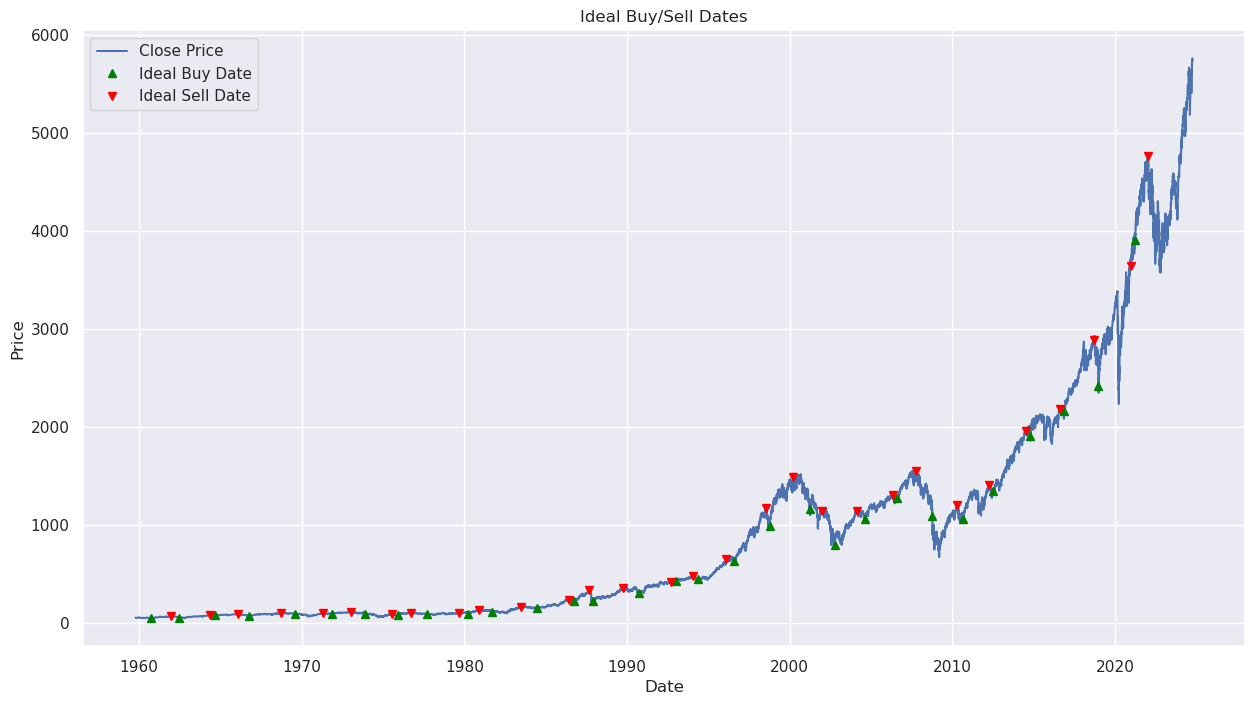

Cumulative Return: 344751.33%


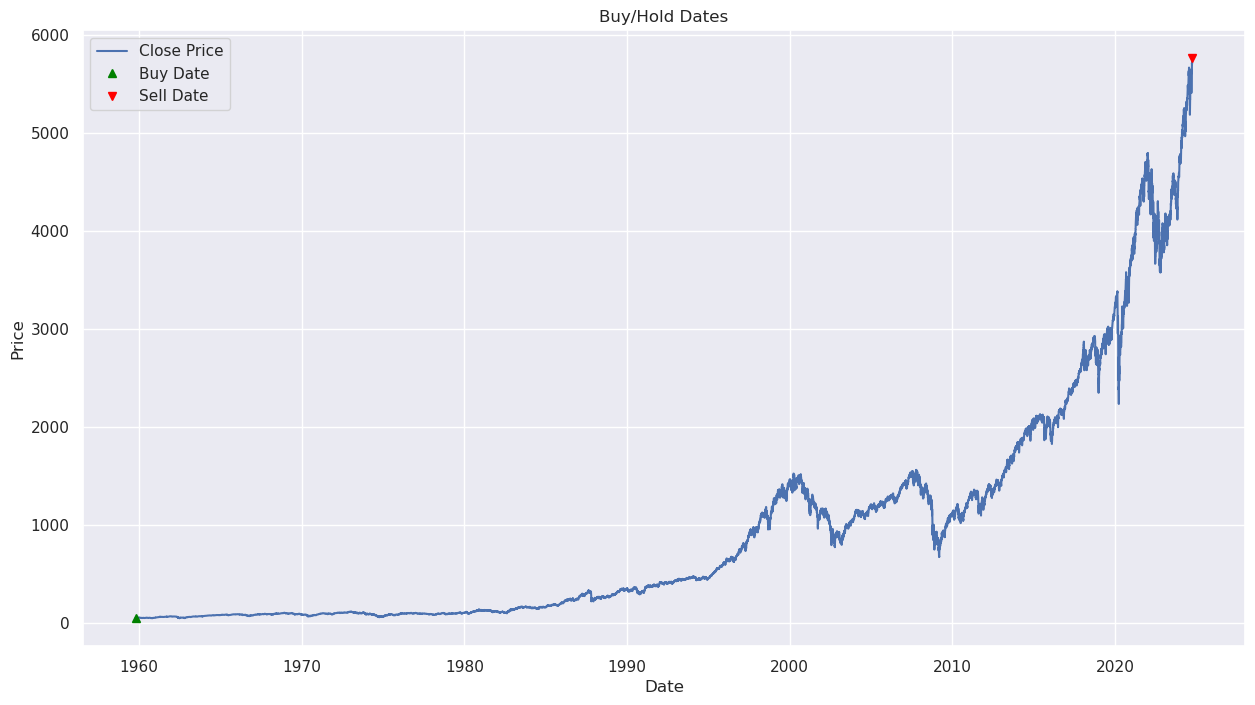

Holding Strategy Return: 9951.42%


In [57]:
def ideal_date_single(binary_col, position: int):
    """
    For each block of consecutive 1s in binary_col, select one index (based on position)
    and return a Series with 1 at only those selected indices.
    """
    result = pd.Series(0, index=binary_col.index)
    blockof1s = []

    for idx, val in binary_col.items():
        if val == 1:
            blockof1s.append(idx)
        elif blockof1s:
            pos = max(min(position, len(blockof1s) - 1), 0)
            selected_idx = blockof1s[pos]
            result.at[selected_idx] = 1
            blockof1s = []

    if blockof1s:
        pos = max(min(position, len(blockof1s) - 1), 0)
        selected_idx = blockof1s[pos]
        result.at[selected_idx] = 1

    return result

def plot_singles(sp):
    # Generate the single buy/sell signals
    sp['ideal_buy_date_single'] = ideal_date_single(sp['ideal_buy_date_expanded'], 2)
    sp['ideal_sell_date_single'] = ideal_date_single(sp['ideal_sell_date_expanded'], 2)

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(15, 8))
    plt.plot(sp.index, sp['close'], label='Close Price')

    # Plot BUY signals
    plt.plot(sp[sp['ideal_buy_date_single'] == 1].index, sp[sp['ideal_buy_date_single'] == 1]['close'], '^', color='green', label='Ideal Buy Date')

    # Plot SELL signals
    plt.plot(sp[sp['ideal_sell_date_single'] == 1].index, sp[sp['ideal_sell_date_single'] == 1]['close'],'v', color='red', label='Ideal Sell Date')

    plt.title('Ideal Buy/Sell Dates')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate Cumulative Return
    buy_dates = sp[sp['ideal_buy_date_single'] == 1].index 
    sell_dates = sp[sp['ideal_sell_date_single'] == 1].index

    # Ensure same length
    n_trades = min(len(buy_dates), len(sell_dates))
    cumulative_return = 1.0

    for i in range(n_trades):
        buy_price = sp.loc[buy_dates[i], 'close']
        sell_price = sp.loc[sell_dates[i], 'close']
        trade_return = (sell_price - buy_price) / buy_price
        cumulative_return *= (1 + trade_return)

    # Cleanup
    drop_cols = ['ideal_buy_date', 'ideal_sell_date', 'ideal_buy)date_single', 'ideal_sell_date_single']
    for cols in drop_cols:
        if cols in sp.columns:
            sp.drop(columns=cols, inplace=True)

    # Print the cumulative return
    cumulative_return = np.round((cumulative_return - 1) * 100, 2)
    print(f"Cumulative Return: {cumulative_return}%")

plot_singles(sp)
holding_returns(sp)

## Stationarity

I'm going to drop ideal_buy_date and ideal_sell_date to use the expanded columns instead. For graphing and return purposes, I will have to collapse the expanded columns into single points.

In [58]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23727 entries, 1959-10-17 to 2024-10-01
Freq: D
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   close                       23727 non-null  float64
 1   volume                      23727 non-null  float64
 2   high_weekly                 23727 non-null  float64
 3   open_weekly                 23727 non-null  float64
 4   volume_weekly               23727 non-null  float64
 5   GDP                         23727 non-null  float64
 6   A191RP1Q027SBEA             23727 non-null  float64
 7   BOGZ1FL135010005Q           23727 non-null  float64
 8   PRS85006091                 23727 non-null  float64
 9   M1V                         23727 non-null  float64
 10  M2V                         23727 non-null  float64
 11  PAYEMS                      23727 non-null  float64
 12  INDPRO                      23727 non-null  float64
 13  CE16OV

Stationarity / ADF 

In [59]:
stationary = []
nonstationary = []
print("ADF Test Results")

sp_adf = sp.copy()


for col in sp_adf.columns:
    # drop binary columns
    if sp_adf[col].dtype == 'int64':
        sp_adf.drop(columns=[col], inplace=True)
        continue

    result = adfuller(sp_adf[col])  
    if result[1] < 0.05:
        stationary.append(col)
    else:
        nonstationary.append(col)
    print(f"{col}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print(f"\n")



ADF Test Results
close: 4.9465535464510495
p-value: 1.0
Non-Stationary


volume: -2.036902350035167
p-value: 0.270630678266156
Non-Stationary


high_weekly: 5.370484061451333
p-value: 1.0
Non-Stationary


open_weekly: 4.717779120099303
p-value: 1.0
Non-Stationary


volume_weekly: -2.17655740573279
p-value: 0.21486350280904426
Non-Stationary


GDP: 6.206628224392378
p-value: 1.0
Non-Stationary


A191RP1Q027SBEA: -10.488769835755791
p-value: 1.1616575000121088e-18
Stationary


BOGZ1FL135010005Q: 7.3552034864885165
p-value: 1.0
Non-Stationary


PRS85006091: -5.470600825209011
p-value: 2.403544071595848e-06
Stationary


M1V: -0.11548583870786254
p-value: 0.947874072223317
Non-Stationary


M2V: -0.1782432630767748
p-value: 0.9410657611310804
Non-Stationary


PAYEMS: -0.6475171919022106
p-value: 0.85987965062768
Non-Stationary


INDPRO: -1.1723586296189488
p-value: 0.685371902850394
Non-Stationary


CE16OV: -0.7600380604663975
p-value: 0.8305797601979573
Non-Stationary


UNRATE: -3.609452036

Run the nonstationary columns through .diff() and check again

In [60]:
# ADF test results in first row NA, so need to drop NA
for col in nonstationary:
    sp_adf[col] = sp_adf[col].diff()
sp_adf.dropna(inplace=True)

for col in sp_adf:
    result = adfuller(sp_adf[col])
    print(f"{col}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print(f"\n")



close: -23.92358959398076
p-value: 0.0
Stationary


volume: -33.40719673452834
p-value: 0.0
Stationary


high_weekly: -22.211569881975933
p-value: 0.0
Stationary


open_weekly: -28.275790395257797
p-value: 0.0
Stationary


volume_weekly: -34.34075074662071
p-value: 0.0
Stationary


GDP: -153.699287371336
p-value: 0.0
Stationary


A191RP1Q027SBEA: -10.488743464763074
p-value: 1.1618306320208092e-18
Stationary


BOGZ1FL135010005Q: -153.20692694103687
p-value: 0.0
Stationary


PRS85006091: -5.470520109864296
p-value: 2.404491364077443e-06
Stationary


M1V: -154.02379222102851
p-value: 0.0
Stationary


M2V: -154.01734023632636
p-value: 0.0
Stationary


PAYEMS: -26.160146062216747
p-value: 0.0
Stationary


INDPRO: -22.025881989147052
p-value: 0.0
Stationary


CE16OV: -26.52362729514462
p-value: 0.0
Stationary


UNRATE: -3.6093772042079584
p-value: 0.005584265655799057
Stationary


CPIAUCSL: -14.12218330808029
p-value: 2.4140527976090645e-26
Stationary


SAHMCURRENT: -7.729591833334882
p-val

Stationarity should be good now. Let's check it out.

In [61]:
sp_adf

,close,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,...,bb_upper_100,bb_middle_100,bb_lower_100,bb_upper_200,bb_middle_200,bb_lower_200,macd,macd_signal,rsi_28,rsi_56
date,,,,,,,,,,,,,,,,,,,,,
1959-10-18,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.8,0.0,3.0,0.000,...,-0.034283,-0.026400,-0.018517,-0.016178,0.009450,0.035078,-0.329707,-0.462800,49.136375,47.969608
1959-10-19,0.000000,0.0,-0.320004,-0.310001,2330000.0,0.0,1.8,0.0,3.0,0.000,...,-0.033382,-0.025800,-0.018218,-0.012695,0.008200,0.029095,-0.306011,-0.446296,49.136375,47.969608
1959-10-20,-0.320004,-290000.0,0.000000,0.000000,0.0,0.0,1.8,0.0,3.0,0.000,...,-0.032048,-0.029000,-0.025952,-0.008005,0.005050,0.018105,-0.297634,-0.430647,46.485927,46.630556
1959-10-21,-0.349998,270000.0,0.000000,0.000000,0.0,0.0,1.8,0.0,3.0,0.000,...,-0.029222,-0.032500,-0.035778,-0.001677,0.001100,0.003877,-0.304112,-0.417328,43.805811,45.224692
1959-10-22,-0.110001,-10000.0,0.000000,0.000000,0.0,0.0,1.8,0.0,3.0,0.000,...,-0.014551,-0.028600,-0.042649,-0.000890,0.000550,0.001990,-0.313577,-0.406406,42.997829,44.792544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,23.110352,766270000.0,0.000000,0.000000,0.0,0.0,5.6,0.0,3.0,0.000,...,6.574075,2.583403,-1.407269,5.153458,3.108401,1.063343,58.433066,41.298277,62.139609,58.836038
2024-09-28,-7.200195,-492650000.0,0.000000,0.000000,0.0,0.0,5.6,0.0,3.0,0.000,...,6.062772,2.511401,-1.039969,4.827275,3.101150,1.375025,60.308431,43.299346,61.495701,58.537713
2024-09-29,0.000000,0.0,0.000000,0.000000,0.0,0.0,5.6,0.0,3.0,0.000,...,5.916538,2.650000,-0.616538,5.110373,2.814500,0.518626,61.786598,45.245373,61.495701,58.537713


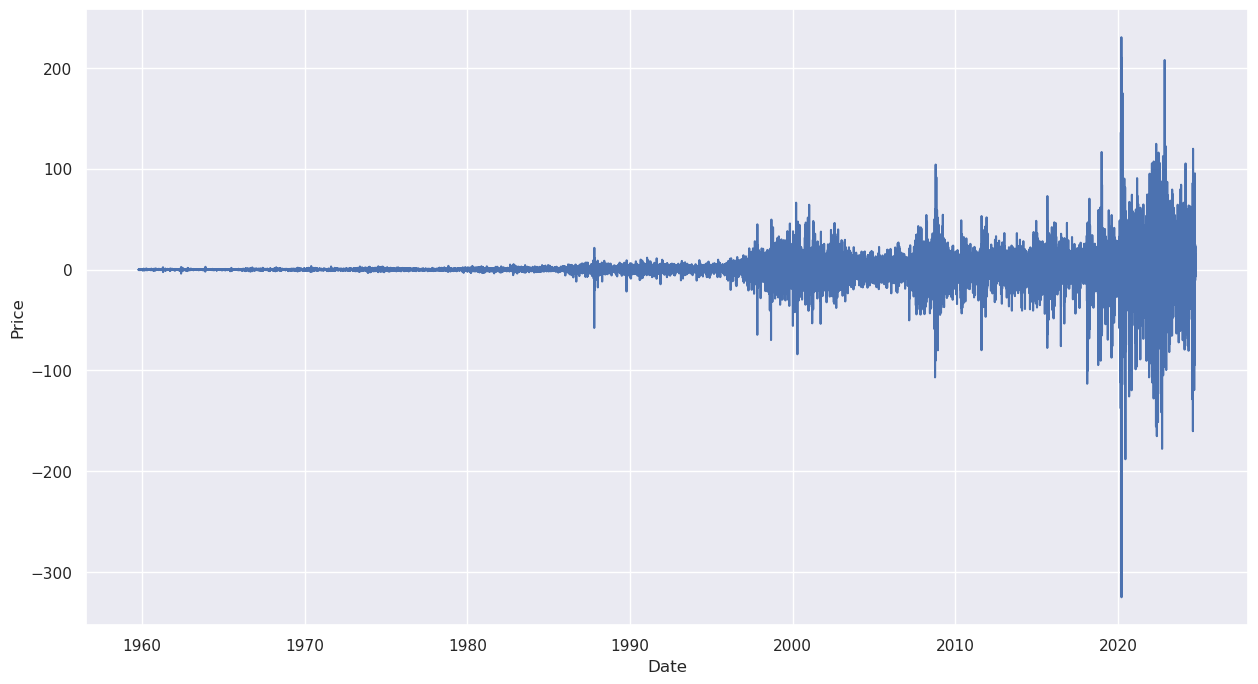

In [62]:
# Style of seaborn
sns.set_theme(style="darkgrid")
# Figure size
plt.figure(figsize=(15, 8))
# Plot the closing price
plt.plot(sp_adf.index, sp_adf['close'], label='Close Price')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.grid(True)

# Show the plot
plt.show()


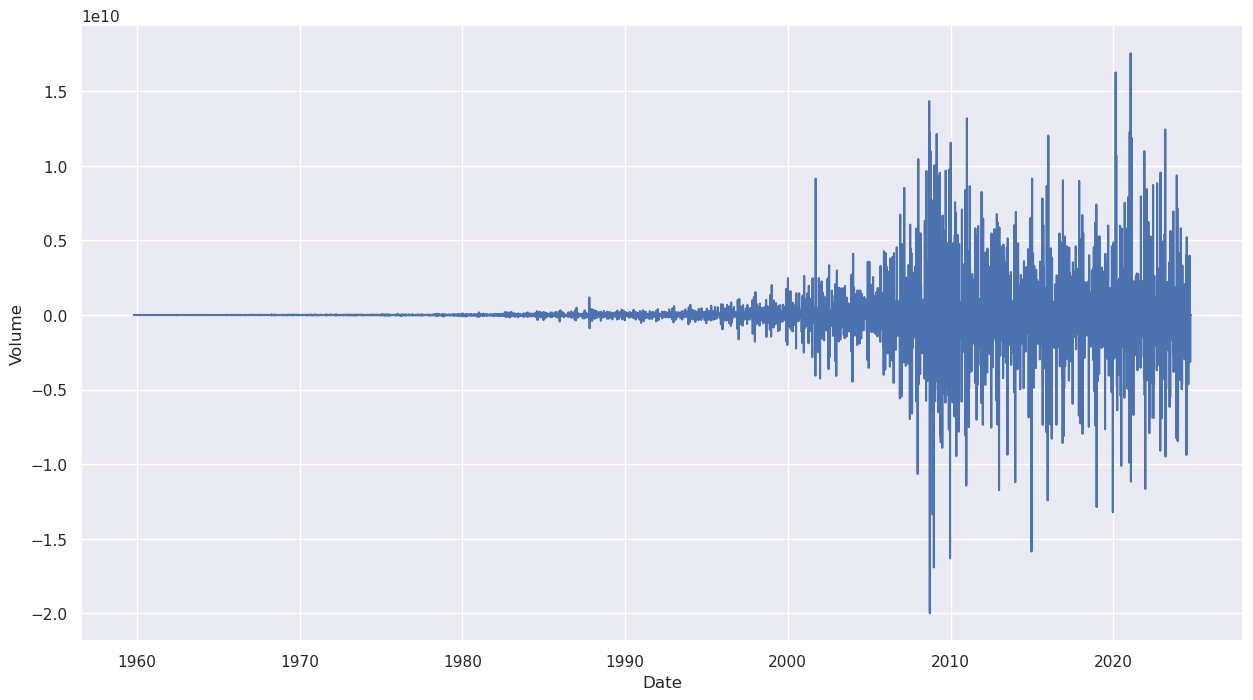

In [63]:
# Style of seaborn
sns.set_theme(style="darkgrid")
# Figure size
plt.figure(figsize=(15, 8))
# Plot the closing price
plt.plot(sp_adf.index, sp_adf['volume_weekly'], label='Weekly Volume')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Volume')

# Add a legend
plt.grid(True)

# Show the plot
plt.show()


## Pearson correlation

Reintroduce binary columns 

In [64]:
sp_adf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23726 entries, 1959-10-18 to 2024-10-01
Freq: D
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close              23726 non-null  float64
 1   volume             23726 non-null  float64
 2   high_weekly        23726 non-null  float64
 3   open_weekly        23726 non-null  float64
 4   volume_weekly      23726 non-null  float64
 5   GDP                23726 non-null  float64
 6   A191RP1Q027SBEA    23726 non-null  float64
 7   BOGZ1FL135010005Q  23726 non-null  float64
 8   PRS85006091        23726 non-null  float64
 9   M1V                23726 non-null  float64
 10  M2V                23726 non-null  float64
 11  PAYEMS             23726 non-null  float64
 12  INDPRO             23726 non-null  float64
 13  CE16OV             23726 non-null  float64
 14  UNRATE             23726 non-null  float64
 15  CPIAUCSL           23726 non-null  float64
 1

In [65]:
sp_concat = sp_adf.copy()
sp_redindex = sp.loc[sp_adf.index]

for col in sp_redindex.columns:
    if sp_redindex[col].dtype == 'int64':
        sp_concat = pd.concat([sp_concat, sp_redindex[col]], axis=1)

sp_concat.dropna(inplace=True)
sp_concat.drop(columns=['ideal_buy_date_single', 'ideal_buy_date_single'], inplace=True)
sp_concat.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23726 entries, 1959-10-18 to 2024-10-01
Freq: D
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   close                       23726 non-null  float64
 1   volume                      23726 non-null  float64
 2   high_weekly                 23726 non-null  float64
 3   open_weekly                 23726 non-null  float64
 4   volume_weekly               23726 non-null  float64
 5   GDP                         23726 non-null  float64
 6   A191RP1Q027SBEA             23726 non-null  float64
 7   BOGZ1FL135010005Q           23726 non-null  float64
 8   PRS85006091                 23726 non-null  float64
 9   M1V                         23726 non-null  float64
 10  M2V                         23726 non-null  float64
 11  PAYEMS                      23726 non-null  float64
 12  INDPRO                      23726 non-null  float64
 13  CE16OV

Pearson correlation matrix heatmap

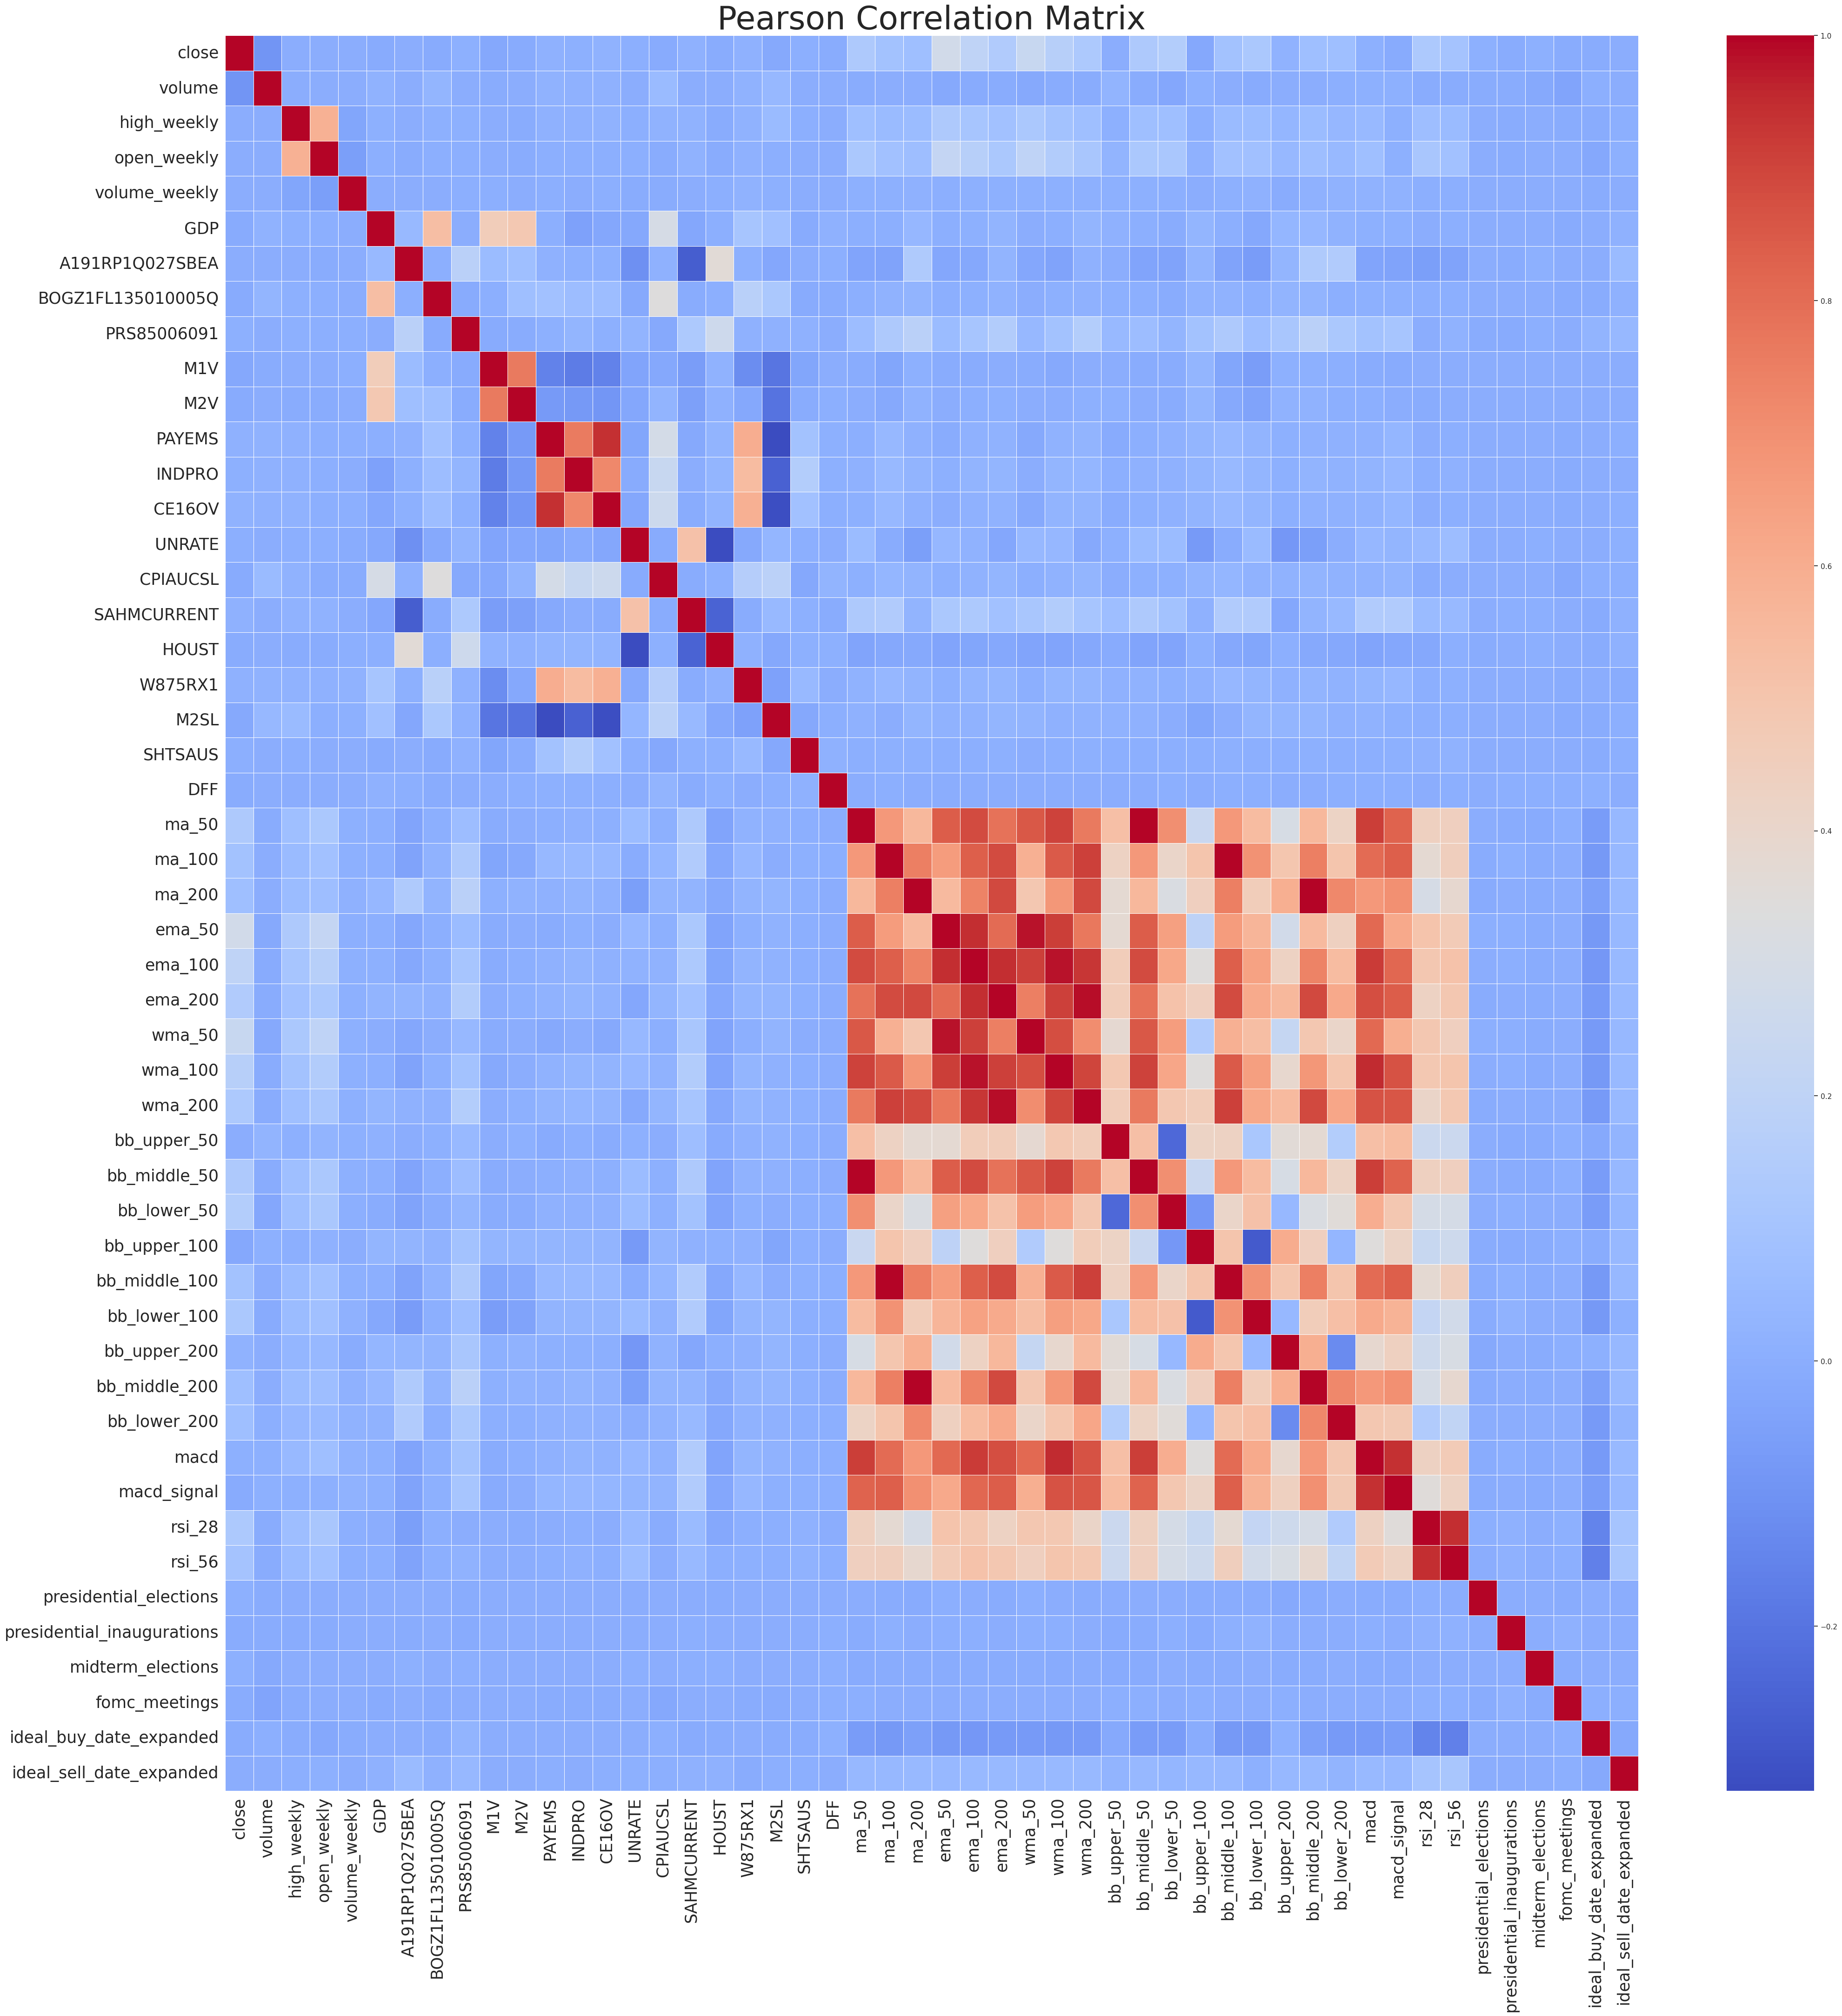

In [66]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


Based on the correlation matrix, there are no clear correlations to the target variables. The main issue I can see is that some of the TA features are highly correlated with each other. I will remove the ones that are most correlated with each other.

In [67]:
sp_concat.drop(columns=['macd_signal', 'rsi_28', 'ema_50', 'CE16OV'], axis=1, inplace=True)

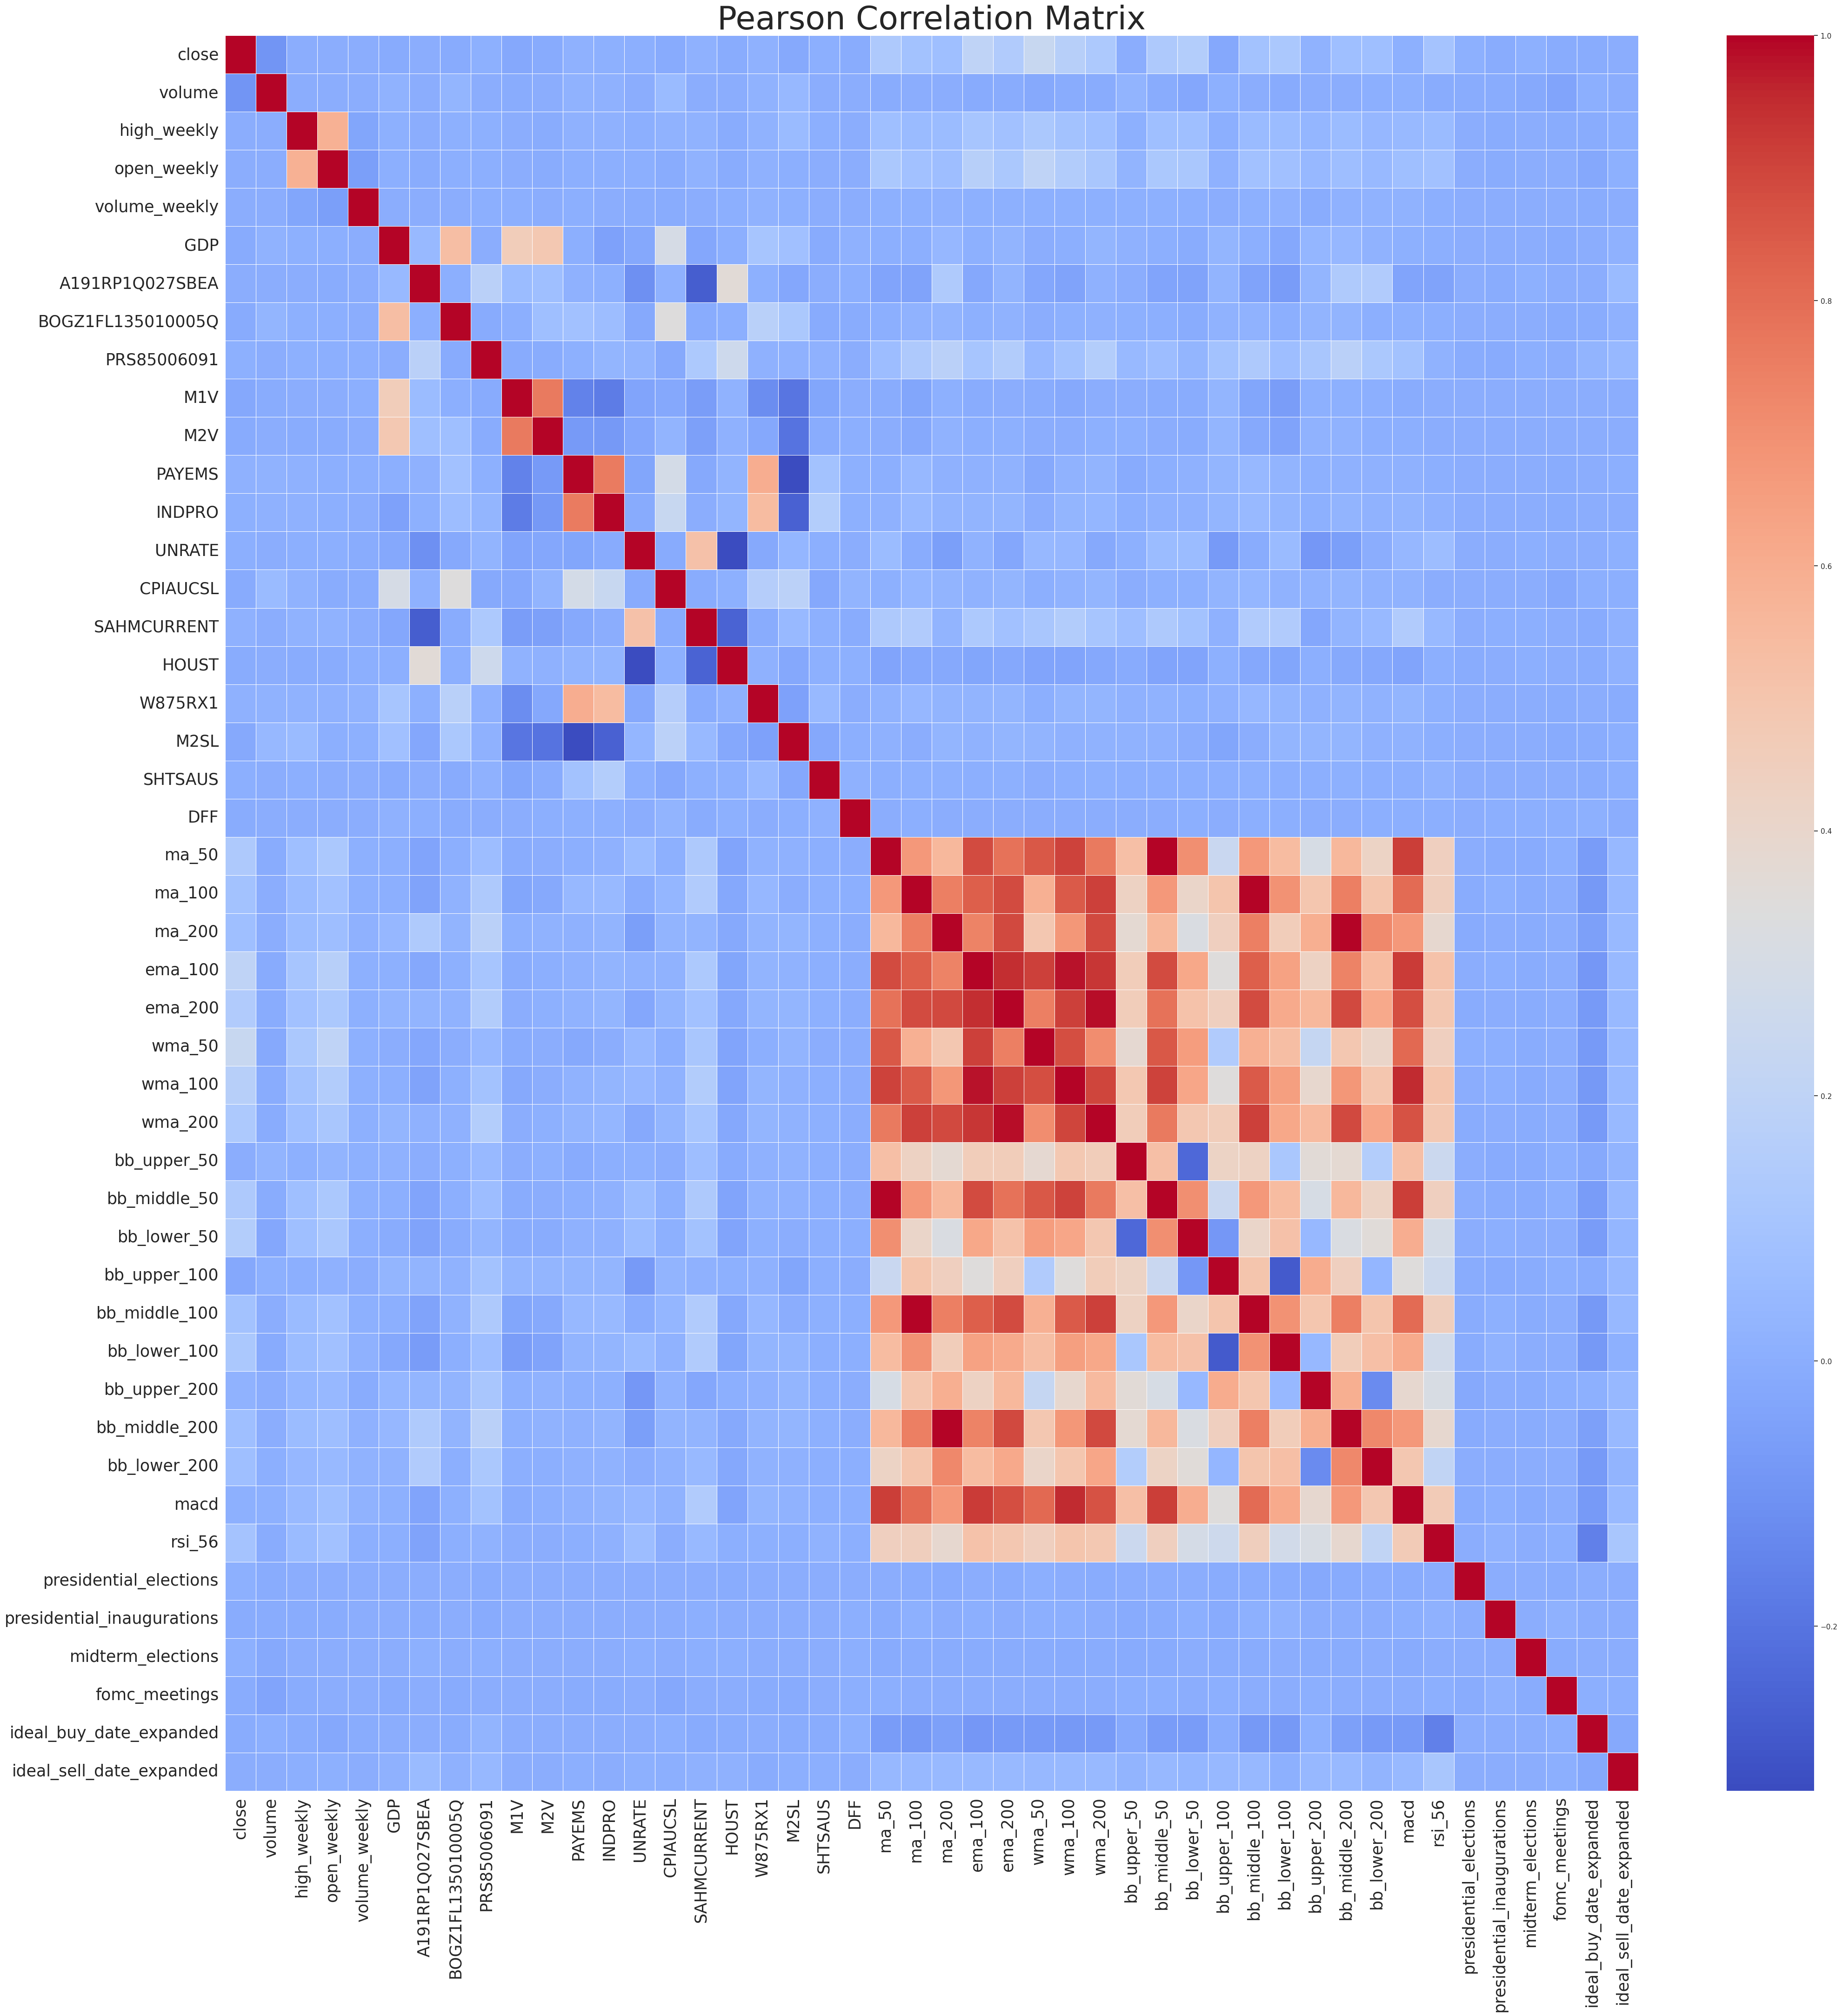

In [68]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


macd, wma, ma, and ema indicators are all highly correlated with each other and bollinger bands. I will remove them. I will also remove M1V and INDPRO.

In [69]:
sp_concat.drop(columns=['macd', 'ma_50', 'ma_100', 'ma_200', 'ema_100', 'ema_200', 'wma_50', 'wma_100', 'wma_200', 'bb_middle_100', 'bb_middle_200', 'bb_middle_50', 'M1V', 'INDPRO'], axis=1, inplace=True)

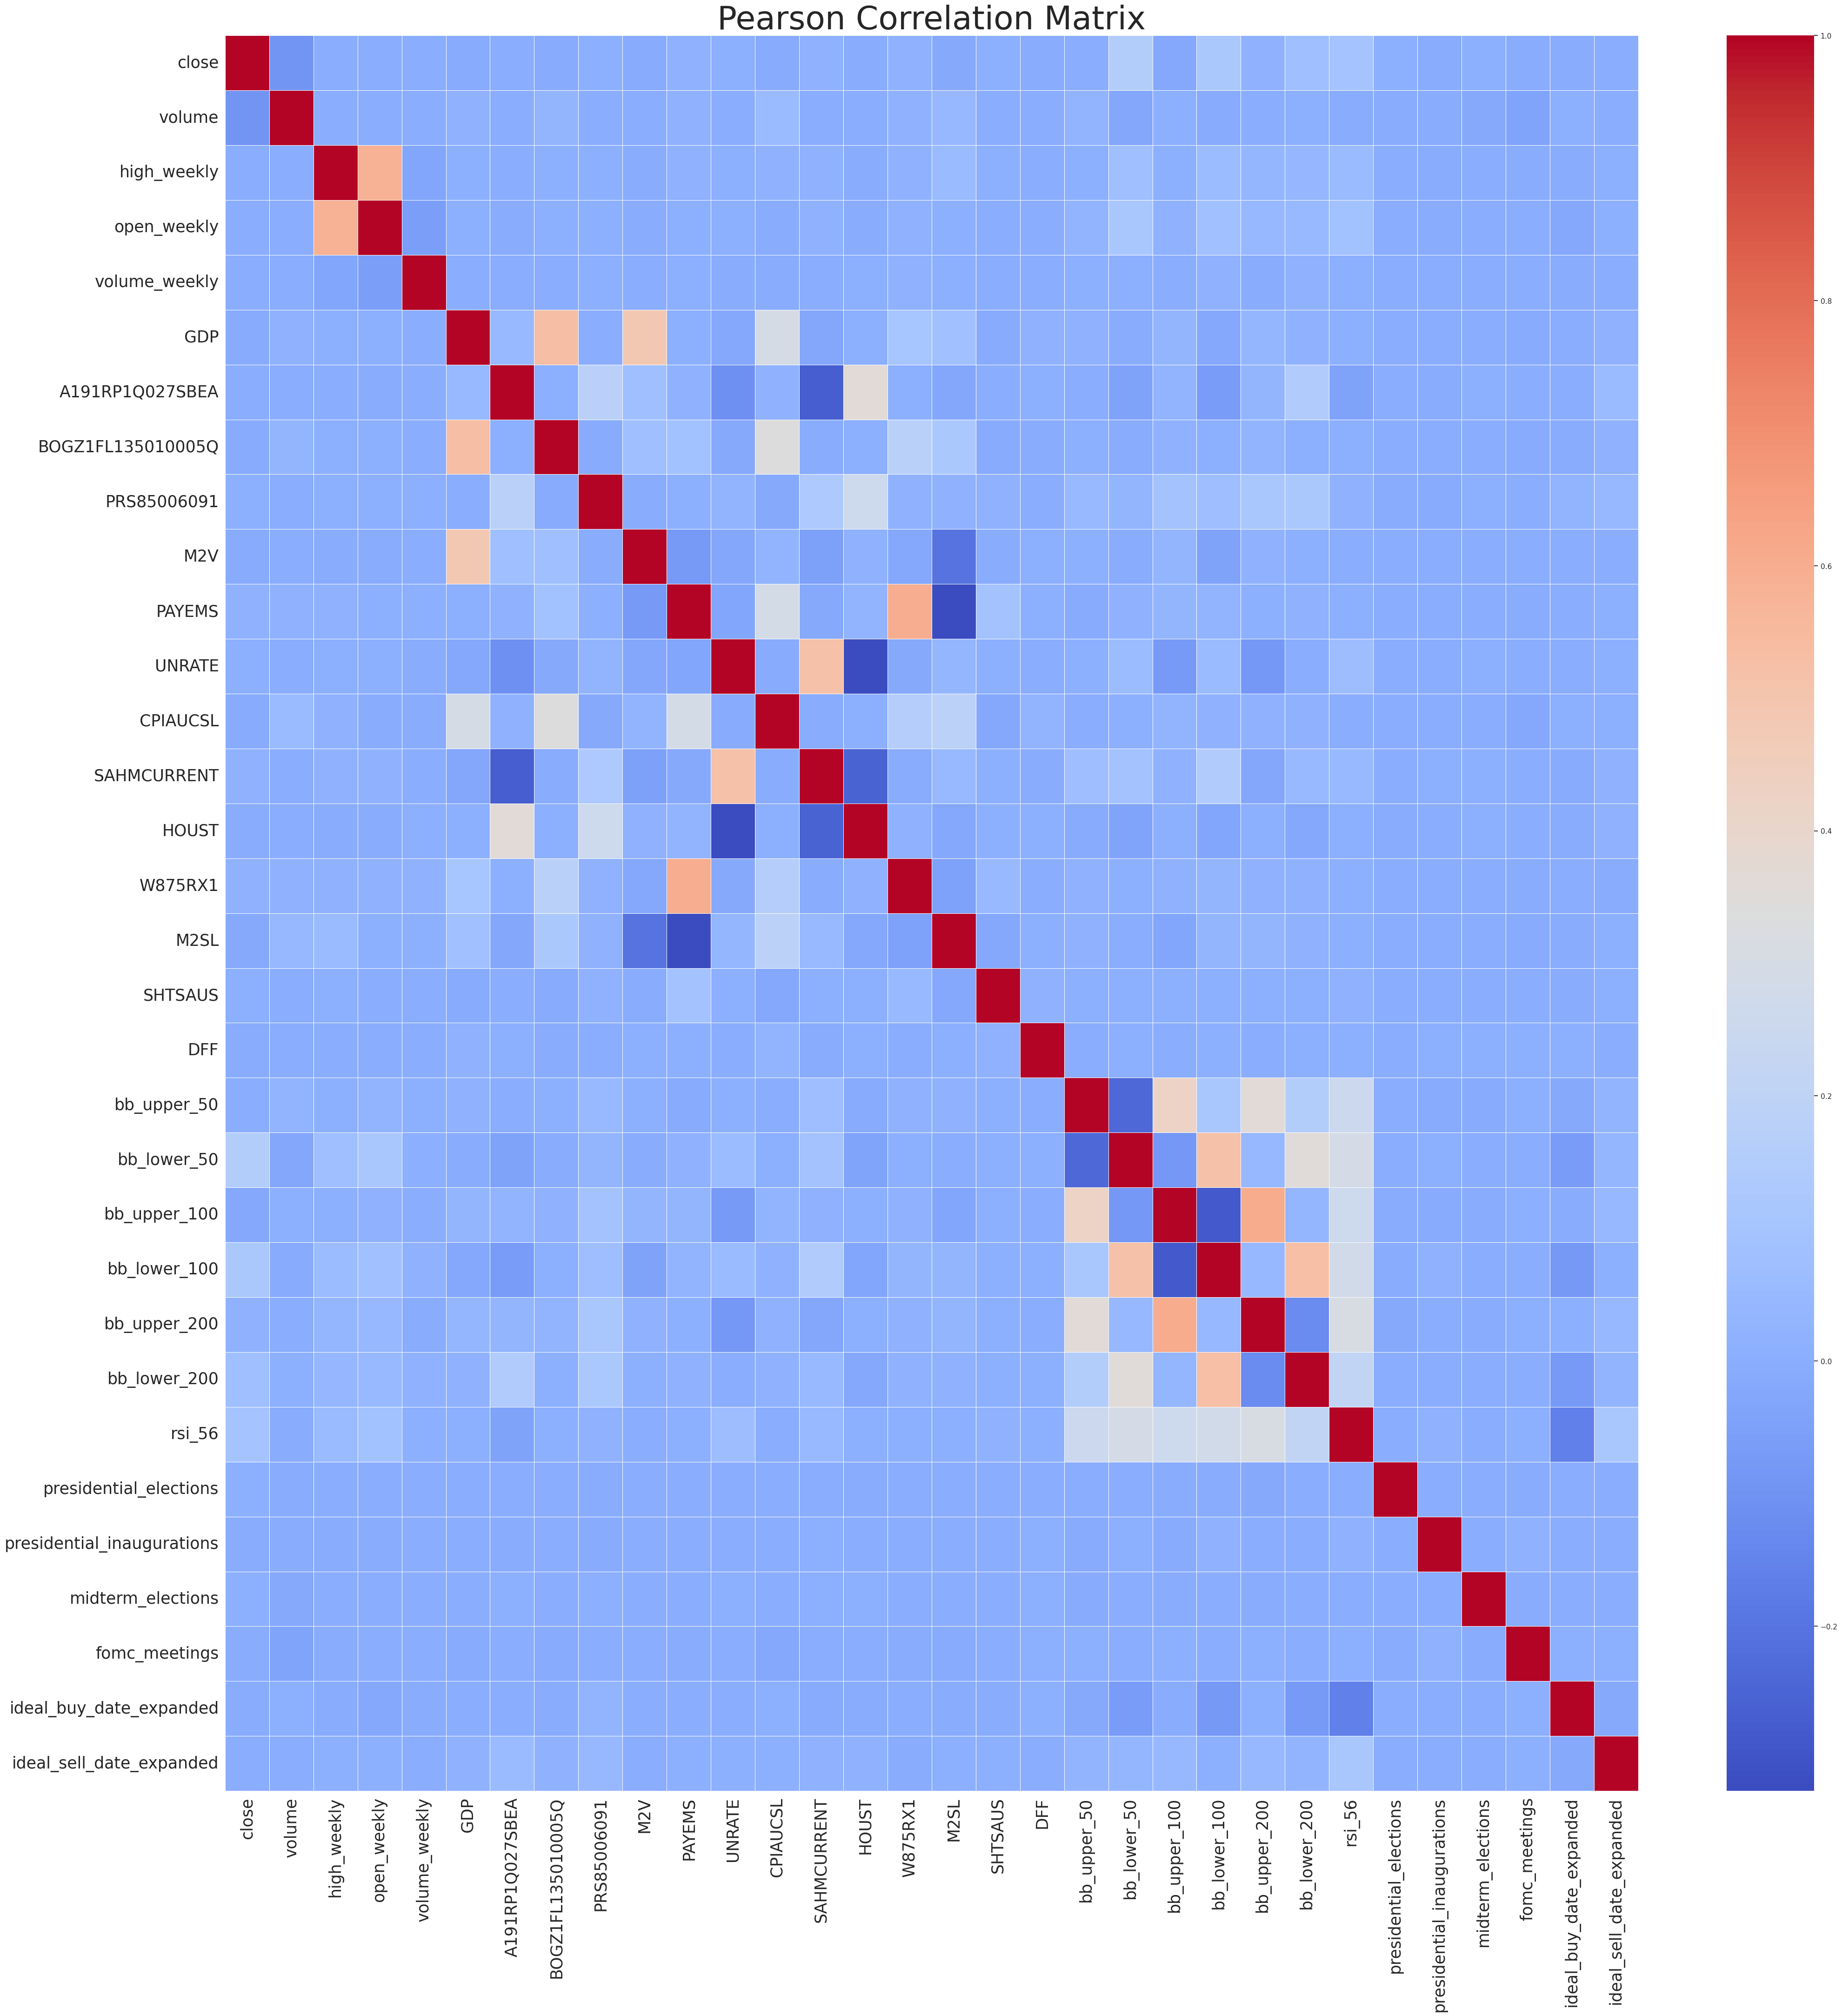

In [70]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


This looks much better, and should improve modeling. All features are equally uncorrelated to the target variables, so I will work with this DF. 

## Modeling

Force GPU usage using TensorFlow combined with CUDA and cuDNN (This was hard to figure out, but I have a good GPU, so this should speed up the modeling a lot)

In [71]:
print(tf.config.list_physical_devices('GPU'))

print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("GPU Device Name: ", tf.test.gpu_device_name())

# This will stop TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


[]
TensorFlow version: 2.13.0
GPU Available:  []
GPU Device Name:  


2025-04-25 23:13:35.889361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-04-25 23:13:35.889379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: daviid-System-Product-Name
2025-04-25 23:13:35.889382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: daviid-System-Product-Name
2025-04-25 23:13:35.889453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.163.1
2025-04-25 23:13:35.889461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.163.1
2025-04-25 23:13:35.889463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.163.1


In [72]:
sp = sp_concat.copy()

### XGBoost

In [73]:
def cmd_and_report_xgb(sp_df):
    # Target variable extraction
    X = sp_df.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

    # Buy model
    y_buy = sp_df['ideal_buy_date_expanded']
    X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

    # Sell model
    y_sell = sp_df['ideal_sell_date_expanded']
    X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)


    buy_model = XGBClassifier(random_state=0)
    buy_model.fit(X_train_buy, y_train_buy)
    y_pred_buy = buy_model.predict(X_test_buy)

    sell_model = XGBClassifier(random_state=0)
    sell_model.fit(X_train_sell, y_train_sell)
    y_pred_sell = sell_model.predict(X_test_sell)

    print("Accuracy:", accuracy_score(y_test_buy, y_pred_buy))
    print("Accuracy:", accuracy_score(y_test_sell, y_pred_sell))

cmd_and_report_xgb(sp)

Accuracy: 0.9882005899705014
Accuracy: 0.9736620311841551


### Troubleshooting Accuracy

Accuracy is too high. There is data leakage that I will troubleshoot

Is the data being split right?

In [96]:
print("Training range:", X_train_buy.index.min(), "to", X_train_buy.index.max())
print("Test range:", X_test_buy.index.min(), "to", X_test_buy.index.max())

Training range: 1959-10-18 00:00:00 to 2011-10-04 00:00:00
Test range: 2011-10-05 00:00:00 to 2024-10-01 00:00:00


Is it the weekly data giving future values? 

This ended up being a problem, so I decided to lag the weekly data by 7 days to remove the future data leakage. 

The general problem is that the target features are very imbalanced. I am going back to expand the target days to +-5 to correct this. I will still drop the weekly features as they would logically result in leakage.

I will also look at other features than accuracy, since my target variables are still quite imbalanced. I will also troubleshoot adding more expansion to my target features.

In [76]:
ideal_buy_sell(180,730,90,365,5,sp)

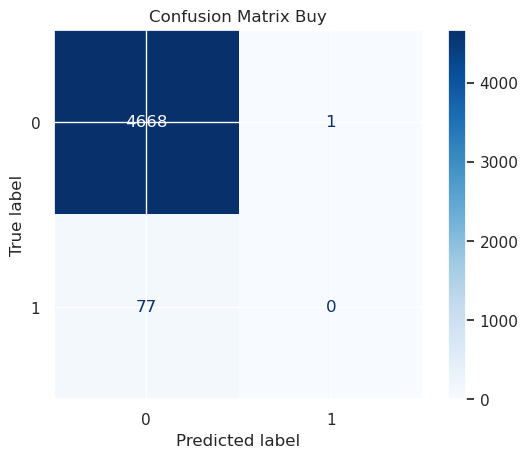

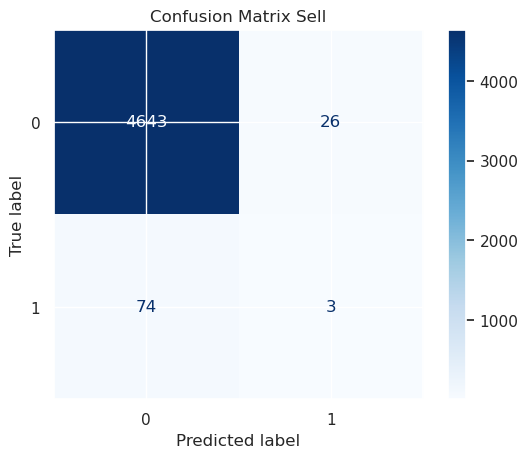

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4669
           1       0.00      0.00      0.00        77

    accuracy                           0.98      4746
   macro avg       0.49      0.50      0.50      4746
weighted avg       0.97      0.98      0.98      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4669
           1       0.10      0.04      0.06        77

    accuracy                           0.98      4746
   macro avg       0.54      0.52      0.52      4746
weighted avg       0.97      0.98      0.97      4746



In [77]:
# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

buy_model = XGBClassifier(random_state=0)
buy_model.fit(X_train_buy, y_train_buy)
y_pred_buy = buy_model.predict(X_test_buy)

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_pred_sell = sell_model.predict(X_test_sell)

# Confusion Matrix
cm_buy = confusion_matrix(y_test_buy, y_pred_buy)
cmd_buy = ConfusionMatrixDisplay(confusion_matrix=cm_buy, display_labels=buy_model.classes_)
cmd_buy.plot(cmap='Blues')
plt.title("Confusion Matrix Buy")
plt.show()

cm_sell = confusion_matrix(y_test_sell, y_pred_sell)
cmd_sell = ConfusionMatrixDisplay(confusion_matrix=cm_sell, display_labels=sell_model.classes_)
cmd_sell.plot(cmap='Blues')
plt.title("Confusion Matrix Sell")
plt.show()



print("Classification Report Buy:")
print(classification_report(y_test_buy, y_pred_buy))

print("Classification Report Sell:")
print(classification_report(y_test_sell, y_pred_sell))



Still showing very high scores around 0 and very low around 1. 

I am going to try different expansion values.



In [78]:
expand_window_values = [2, 3, 4, 5, 6, 7, 8, 9]

for expand_window in expand_window_values:
    ideal_buy_sell(180,730,90,365,expand_window,sp)

    # Drop label columns from features
    X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

    # Buy model
    y_buy = sp['ideal_buy_date_expanded']
    X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

    buy_model = XGBClassifier(random_state=0)
    buy_model.fit(X_train_buy, y_train_buy)
    y_pred_buy = buy_model.predict(X_test_buy)
    f1_buy = f1_score(y_test_buy, y_pred_buy, pos_label=1)


    # Sell model
    y_sell = sp['ideal_sell_date_expanded']
    X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

    sell_model = XGBClassifier(random_state=0)
    sell_model.fit(X_train_sell, y_train_sell)
    y_pred_sell = sell_model.predict(X_test_sell)
    f1_sell = f1_score(y_test_sell, y_pred_sell, pos_label=1)
    
    print(f"#{expand_window}: f1_score = {f1_buy}")
    print(f"#{expand_window}: f1_score = {f1_sell}")


#2: f1_score = 0.0
#2: f1_score = 0.043478260869565216
#3: f1_score = 0.0
#3: f1_score = 0.03773584905660377
#4: f1_score = 0.0
#4: f1_score = 0.0273972602739726
#5: f1_score = 0.0
#5: f1_score = 0.05660377358490566
#6: f1_score = 0.0
#6: f1_score = 0.05
#7: f1_score = 0.0
#7: f1_score = 0.14906832298136646
#8: f1_score = 0.0
#8: f1_score = 0.0
#9: f1_score = 0.0
#9: f1_score = 0.023255813953488372


5 and 6 look best. I will look closer at their Classification Reports.

In [79]:
expand_window_values = [5, 6]

for expand_window in expand_window_values:
    ideal_buy_sell(180,730,90,365,expand_window,sp)

    # Drop label columns from features
    X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

    # Buy model
    y_buy = sp['ideal_buy_date_expanded']
    X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

    buy_model = XGBClassifier(random_state=0)
    buy_model.fit(X_train_buy, y_train_buy)
    y_pred_buy = buy_model.predict(X_test_buy)
    f1_buy = f1_score(y_test_buy, y_pred_buy, pos_label=1)


    # Sell model
    y_sell = sp['ideal_sell_date_expanded']
    X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

    sell_model = XGBClassifier(random_state=0)
    sell_model.fit(X_train_sell, y_train_sell)
    y_pred_sell = sell_model.predict(X_test_sell)
    f1_sell = f1_score(y_test_sell, y_pred_sell, pos_label=1)
    
    print(f"#{expand_window}: f1_score = {f1_buy}")
    print(f"#{expand_window}: f1_score = {f1_sell}")
    # Classification Report
    print("Classification Report Buy:")
    print(classification_report(y_test_buy, y_pred_buy))

    print("Classification Report Sell:")
    print(classification_report(y_test_sell, y_pred_sell))

#5: f1_score = 0.0
#5: f1_score = 0.05660377358490566
Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4669
           1       0.00      0.00      0.00        77

    accuracy                           0.98      4746
   macro avg       0.49      0.50      0.50      4746
weighted avg       0.97      0.98      0.98      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4669
           1       0.10      0.04      0.06        77

    accuracy                           0.98      4746
   macro avg       0.54      0.52      0.52      4746
weighted avg       0.97      0.98      0.97      4746

#6: f1_score = 0.0
#6: f1_score = 0.05
Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4655
           1       0.00      0.00      0.00        91

    acc

/home/daviid/miniconda3/envs/dtsc691/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daviid/miniconda3/envs/dtsc691/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daviid/miniconda3/envs/dtsc691/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

5 seems to be the best. I will use this for the final model.

In [80]:
ideal_buy_sell(180,730,90,365,5,sp) 

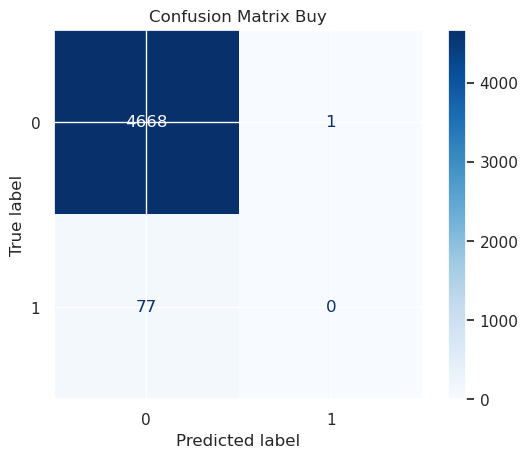

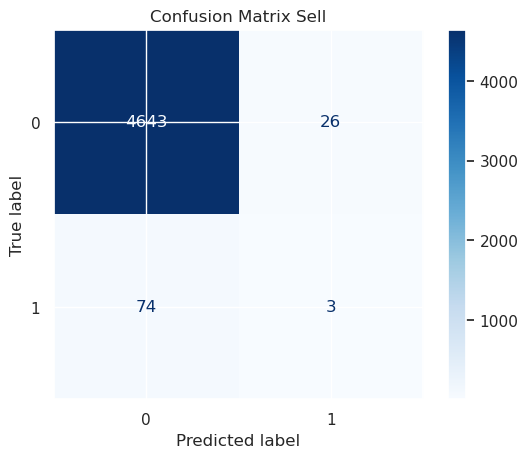

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4669
           1       0.00      0.00      0.00        77

    accuracy                           0.98      4746
   macro avg       0.49      0.50      0.50      4746
weighted avg       0.97      0.98      0.98      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4669
           1       0.10      0.04      0.06        77

    accuracy                           0.98      4746
   macro avg       0.54      0.52      0.52      4746
weighted avg       0.97      0.98      0.97      4746



In [81]:
# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

buy_model = XGBClassifier(random_state=0)
buy_model.fit(X_train_buy, y_train_buy)
y_pred_buy = buy_model.predict(X_test_buy)

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_pred_sell = sell_model.predict(X_test_sell)

# Confusion Matrix
cm_buy = confusion_matrix(y_test_buy, y_pred_buy)
cmd_buy = ConfusionMatrixDisplay(confusion_matrix=cm_buy, display_labels=buy_model.classes_)
cmd_buy.plot(cmap='Blues')
plt.title("Confusion Matrix Buy")
plt.show()

cm_sell = confusion_matrix(y_test_sell, y_pred_sell)
cmd_sell = ConfusionMatrixDisplay(confusion_matrix=cm_sell, display_labels=sell_model.classes_)
cmd_sell.plot(cmap='Blues')
plt.title("Confusion Matrix Sell")
plt.show()

# Classification Report
print("Classification Report Buy:")
print(classification_report(y_test_buy, y_pred_buy))

print("Classification Report Sell:")
print(classification_report(y_test_sell, y_pred_sell))

Now I will try using decreasing the classification threshold and using the scale_pos_weight to improve the model's performance.

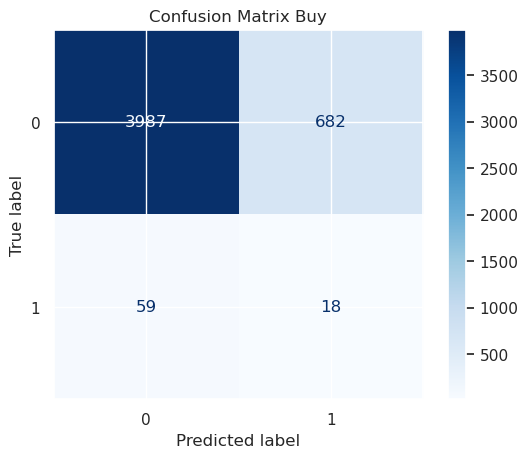

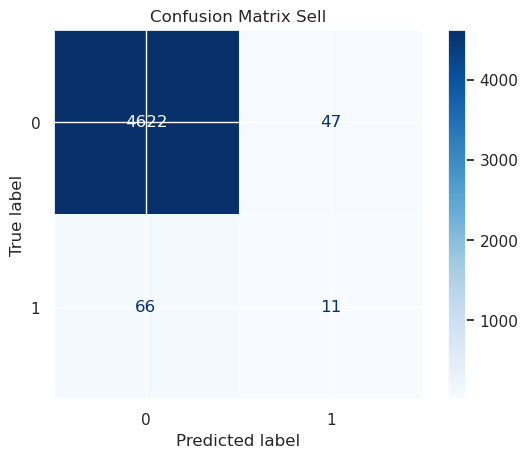

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4669
           1       0.03      0.23      0.05        77

    accuracy                           0.84      4746
   macro avg       0.51      0.54      0.48      4746
weighted avg       0.97      0.84      0.90      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.19      0.14      0.16        77

    accuracy                           0.98      4746
   macro avg       0.59      0.57      0.58      4746
weighted avg       0.97      0.98      0.97      4746



In [82]:
def cmd_and_report_xgb(sp_df):
    # Target variable extraction
    X = sp_df.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

    # Buy model
    y_buy = sp_df['ideal_buy_date_expanded']
    X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

    # Calculate scale_pos_weight
    n_positive = np.sum(y_train_buy == 1)
    n_negative = np.sum(y_train_buy == 0)
    scale_weight = n_negative / n_positive

    # Train model with scale_pos_weight
    buy_model = XGBClassifier(random_state=0, scale_pos_weight=scale_weight)

    buy_model.fit(X_train_buy, y_train_buy)
    y_proba_buy = buy_model.predict_proba(X_test_buy)[:, 1]
    y_pred_buy_threshold = (y_proba_buy > 0.001).astype(int)  

    # Sell model
    y_sell = sp['ideal_sell_date_expanded']
    X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

    # Calculate scale_pos_weight
    n_positive = np.sum(y_train_sell == 1)
    n_negative = np.sum(y_train_sell == 0)
    scale_weight = n_negative / n_positive

    # Train model with scale_pos_weight
    sell_model = XGBClassifier(random_state=0, scale_pos_weight=scale_weight)

    sell_model = XGBClassifier(random_state=0)
    sell_model.fit(X_train_sell, y_train_sell)
    y_proba_sell = sell_model.predict_proba(X_test_sell)[:, 1]
    y_pred_sell_threshold = (y_proba_sell > 0.32).astype(int)  


    # Classification Report
    cm_buy = confusion_matrix(y_test_buy, y_pred_buy_threshold)
    cmd_buy = ConfusionMatrixDisplay(confusion_matrix=cm_buy, display_labels=buy_model.classes_)
    cmd_buy.plot(cmap='Blues')
    plt.title("Confusion Matrix Buy")
    plt.show()

    cm_sell = confusion_matrix(y_test_sell, y_pred_sell_threshold)
    cmd_sell = ConfusionMatrixDisplay(confusion_matrix=cm_sell, display_labels=sell_model.classes_)
    cmd_sell.plot(cmap='Blues')
    plt.title("Confusion Matrix Sell")
    plt.show()

    # Confusion Matrix
    print("Classification Report Buy:")
    print(classification_report(y_test_buy, y_pred_buy_threshold))

    print("Classification Report Sell:")
    print(classification_report(y_test_sell, y_pred_sell_threshold))

cmd_and_report_xgb(sp)

I will use a Precision-Recall Threshold Curve to optimize threshold. (these optimal values have been added above after doing testing below)

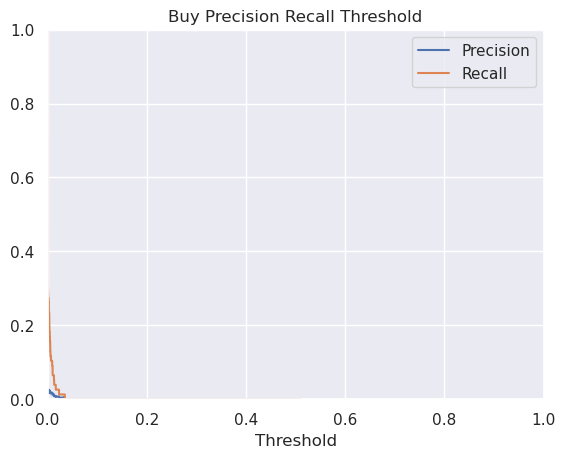

In [83]:
def precision_recall_buy():
    y_proba_buy = buy_model.predict_proba(X_test_buy)[:, 1]
    y_proba_buy = buy_model.predict_proba(X_test_buy)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test_buy, y_proba_buy)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.title('Buy Precision Recall Threshold')
    plt.grid(visible=True)
    plt.xlim(0,1) 
    plt.ylim(0,1)
    plt.show()
precision_recall_buy()

0.001 threshold seems best for Buy (had to zoom in on the graph to see it)

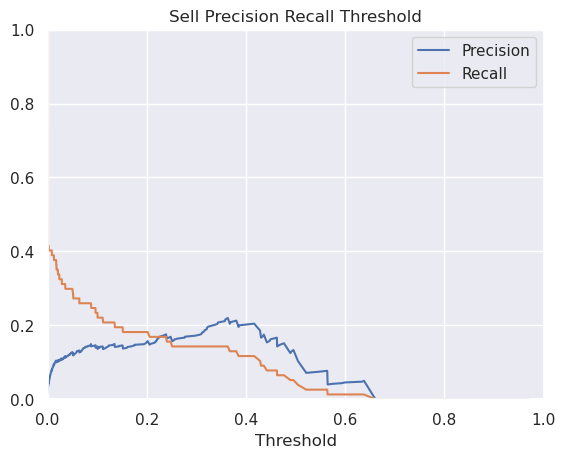

In [84]:
def precision_recall_sell():
    y_proba_sell = sell_model.predict_proba(X_test_sell)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test_sell, y_proba_sell)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.title('Sell Precision Recall Threshold')
    plt.grid(visible=True)
    plt.xlim(0,1) 
    plt.ylim(0,1)
    plt.show()
precision_recall_sell()

0.2 seems best for Sell

These are not great results, but they are much better than without the threshold and scale_pos_weight.

New:
              precision    recall  f1-score   

    1           0.03      0.22      0.05
    1           0.19      0.14      0.16
          
Old:
              precision    recall  f1-score   

    1           0.00      0.00      0.00
    1           0.10      0.04      0.06

XGBoost Feature Importance (including zero importance features)

Figure out which features are missing. 

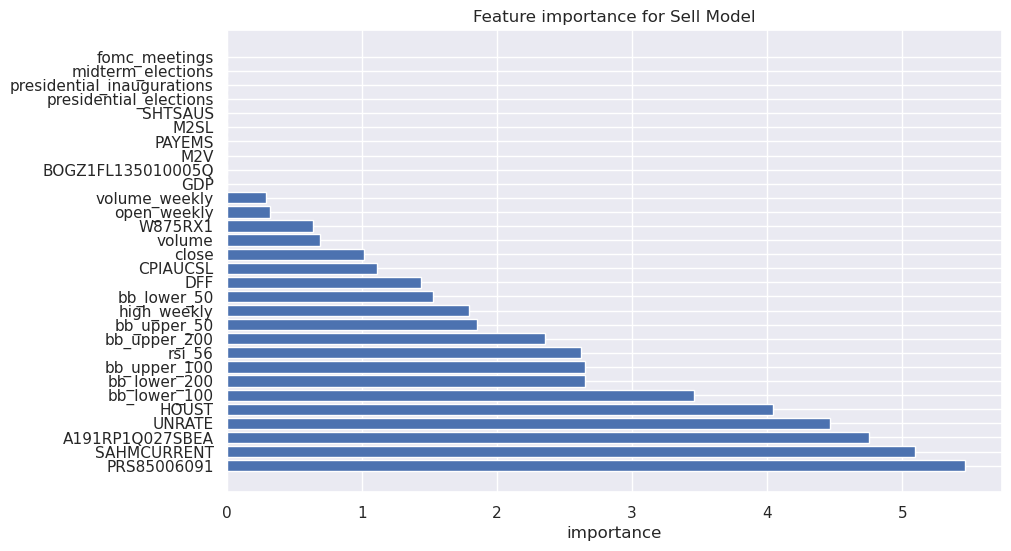

In [85]:
importance = sell_model.get_booster().get_score(importance_type='gain')

features = X_train_sell.columns  

for feature in features:
    if feature not in importance:
        importance[feature] = 0

# Convert dictionary to a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['importance'])
plt.xlabel('importance')
plt.title('Feature importance for Sell Model')
plt.show()


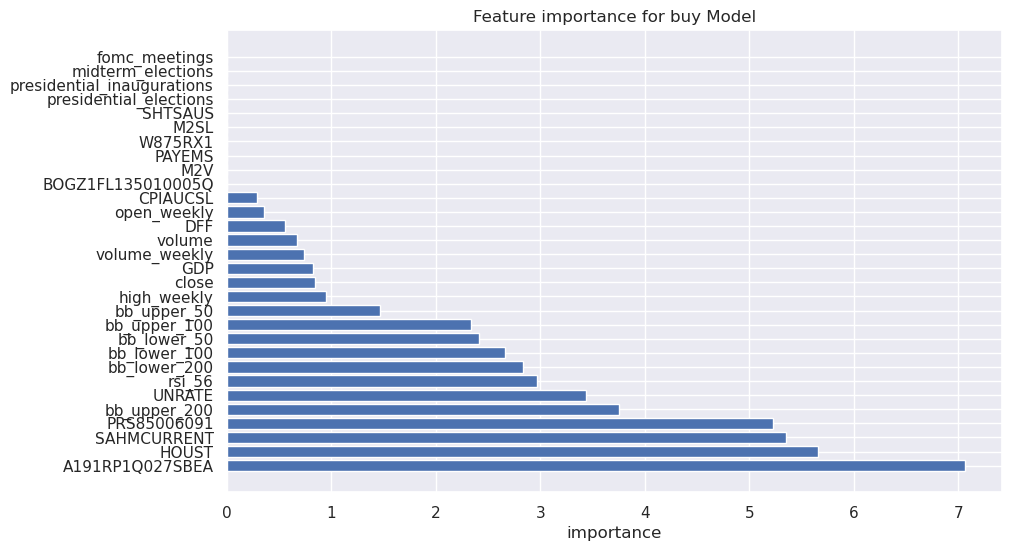

In [86]:
importance = buy_model.get_booster().get_score(importance_type='gain')

features = X_train_buy.columns  

for feature in features:
    if feature not in importance:
        importance[feature] = 0

# Convert dictionary to a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['importance'])
plt.xlabel('importance')
plt.title('Feature importance for buy Model')
plt.show()


Drop the least important features. I will remove these and retrain the model and evaluate the results.

In [87]:
sp_trim_xgb = sp.copy()
sp_trim_xgb.drop(columns=['fomc_meetings', 'presidential_elections', 'presidential_inaugurations', 'SHTSAUS', 'midterm_elections', 'M2SL', 'PAYEMS', 'M2V', 'BOGZ1FL135010005Q', 'open_weekly', 'volume_weekly'], inplace=True)

### Outlier detection 

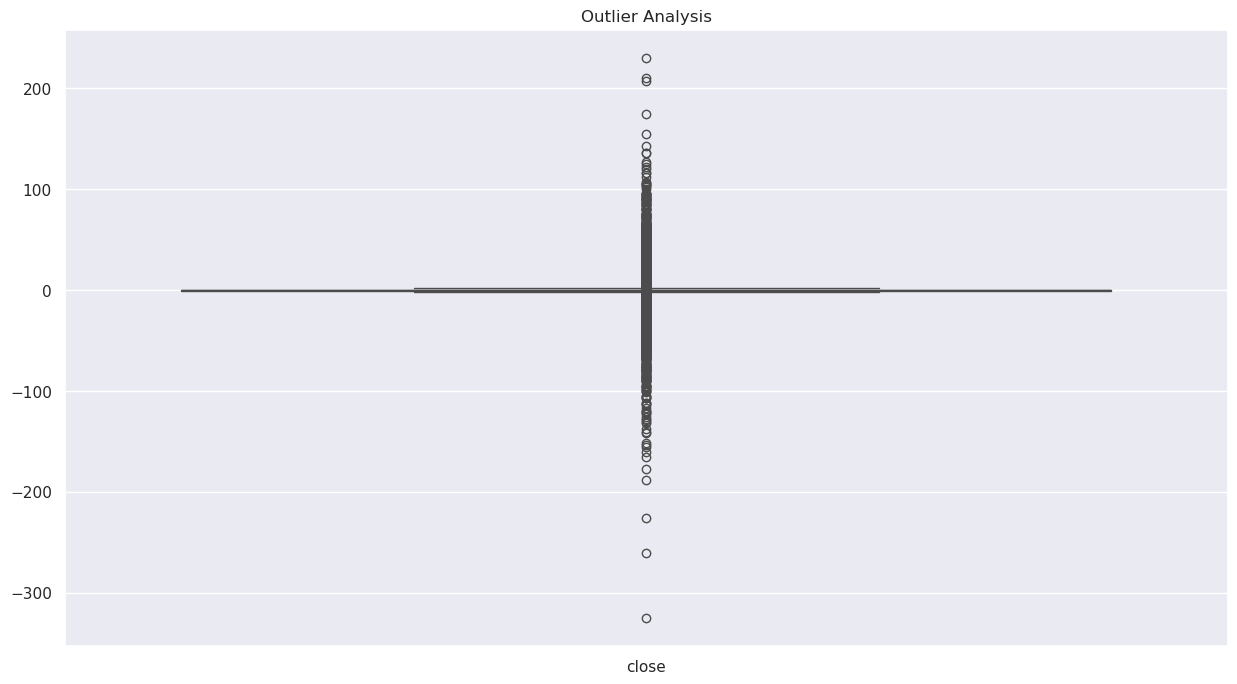

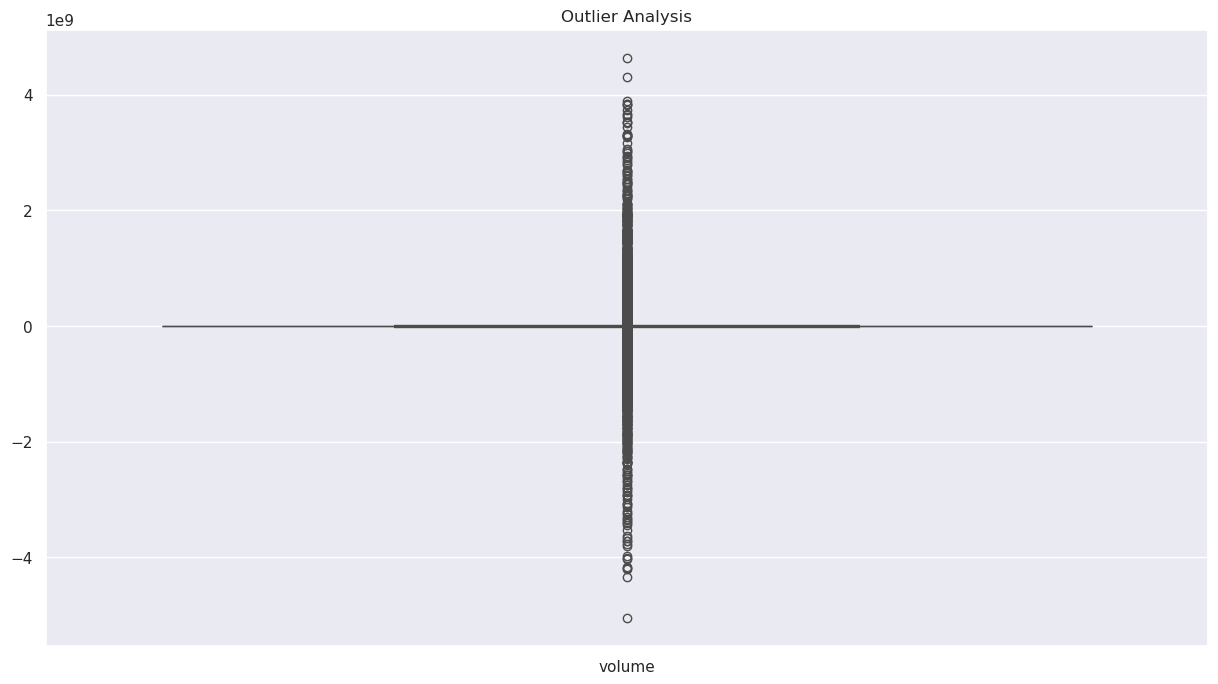

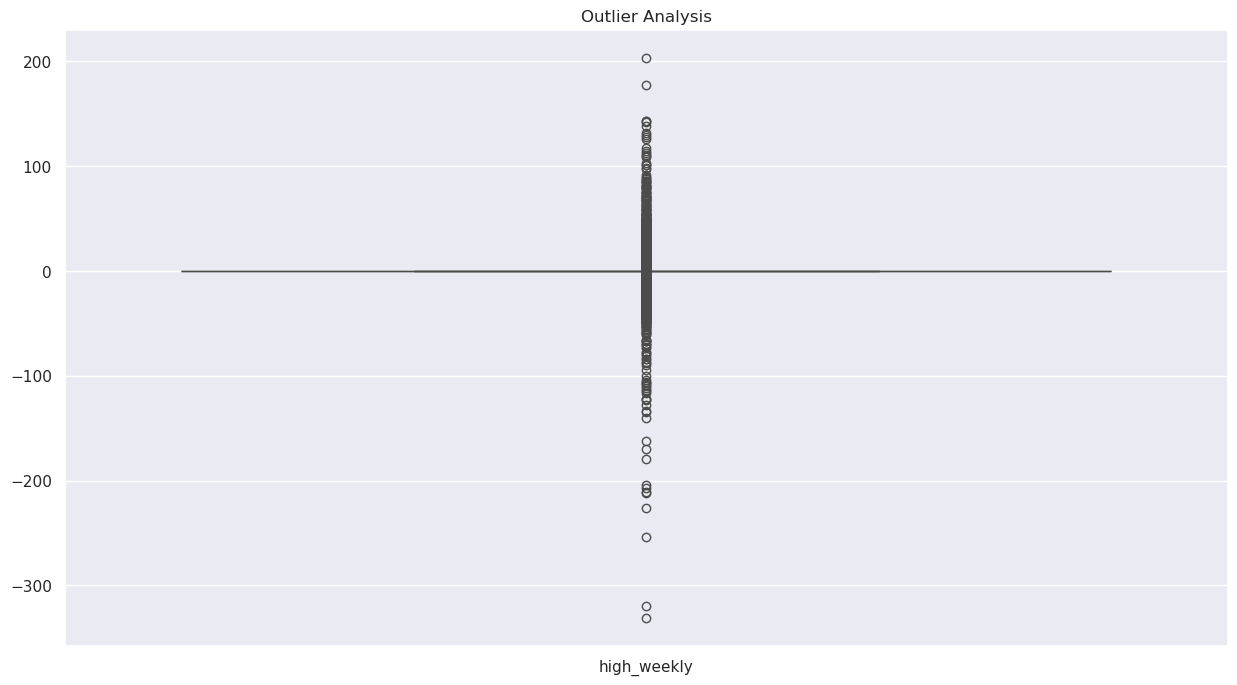

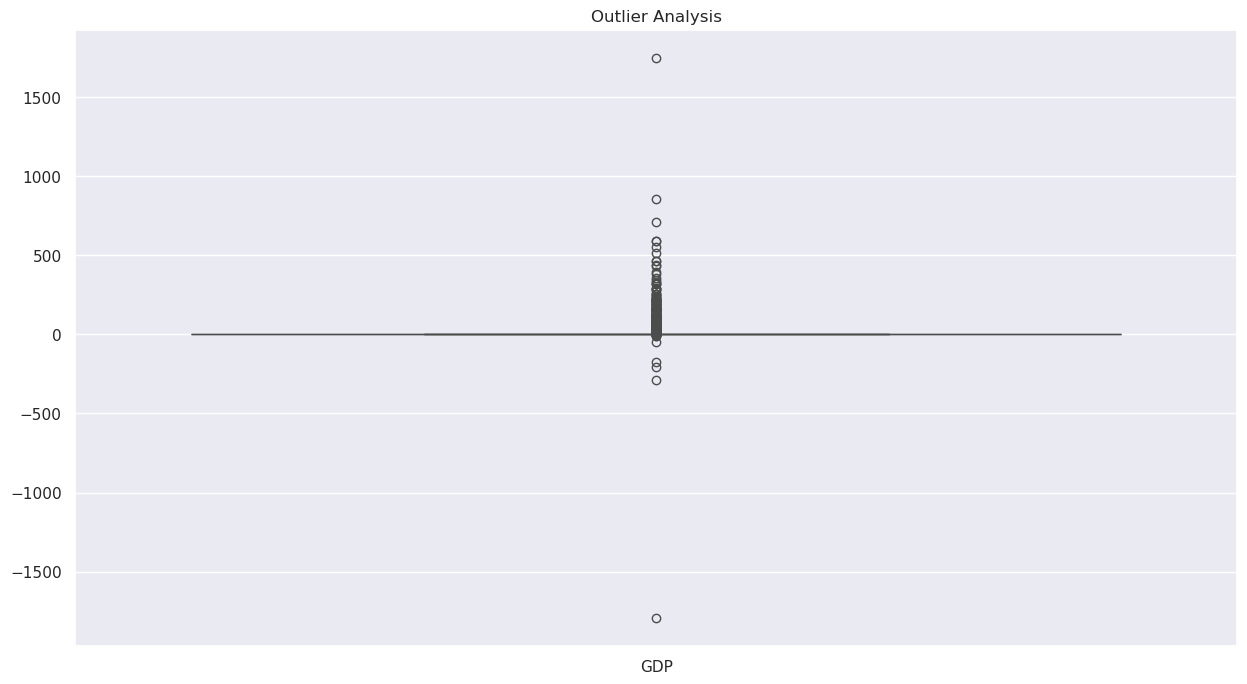

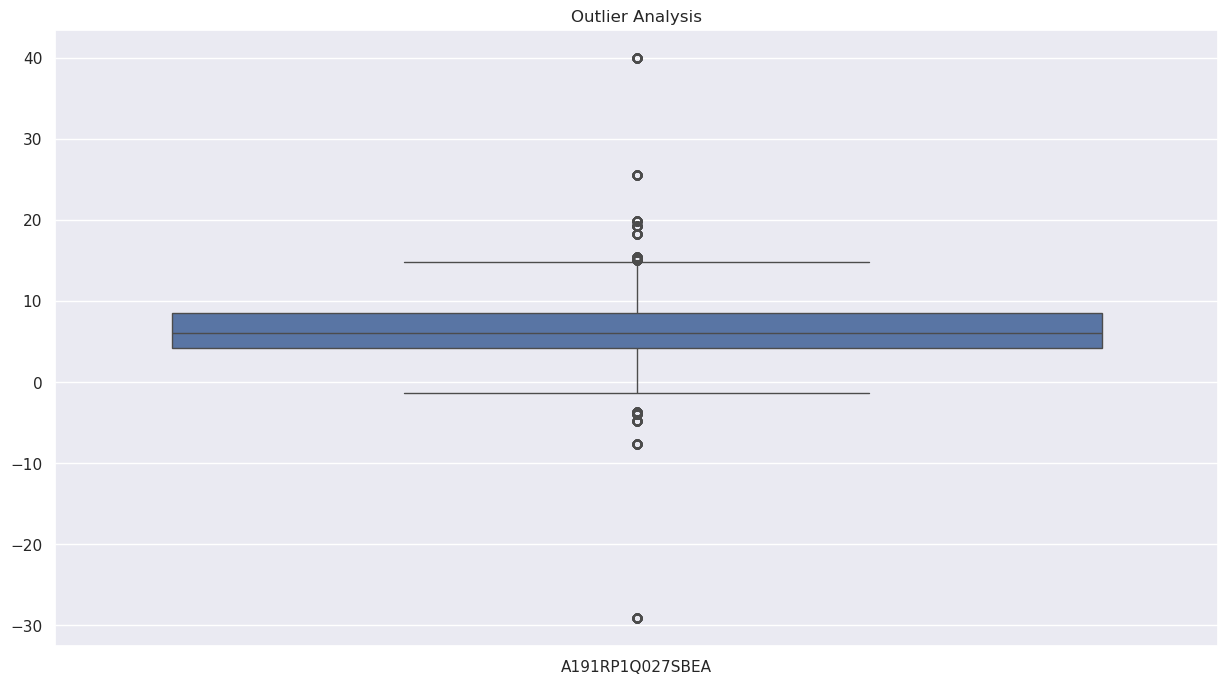

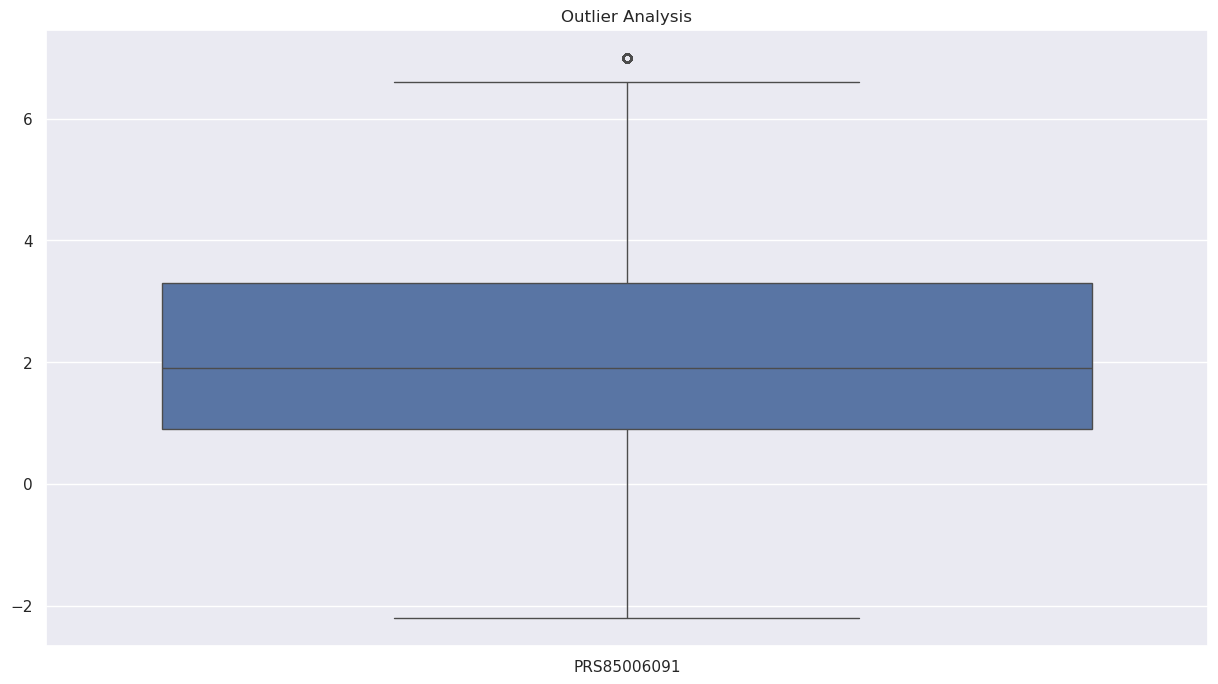

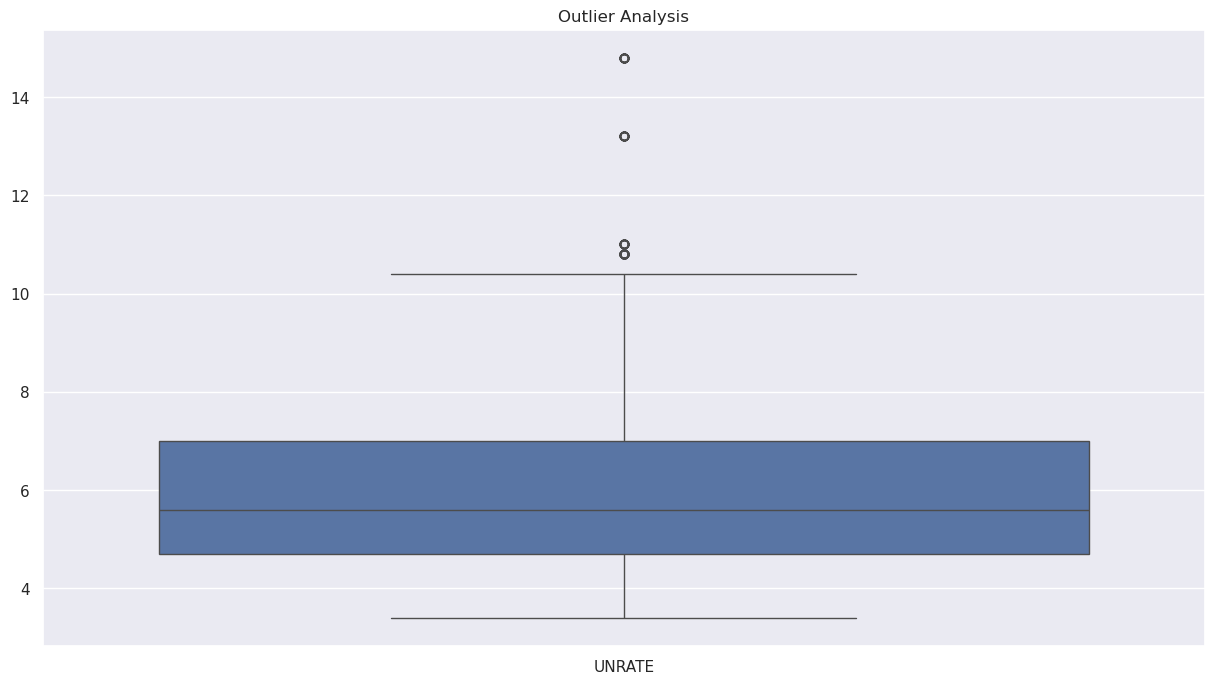

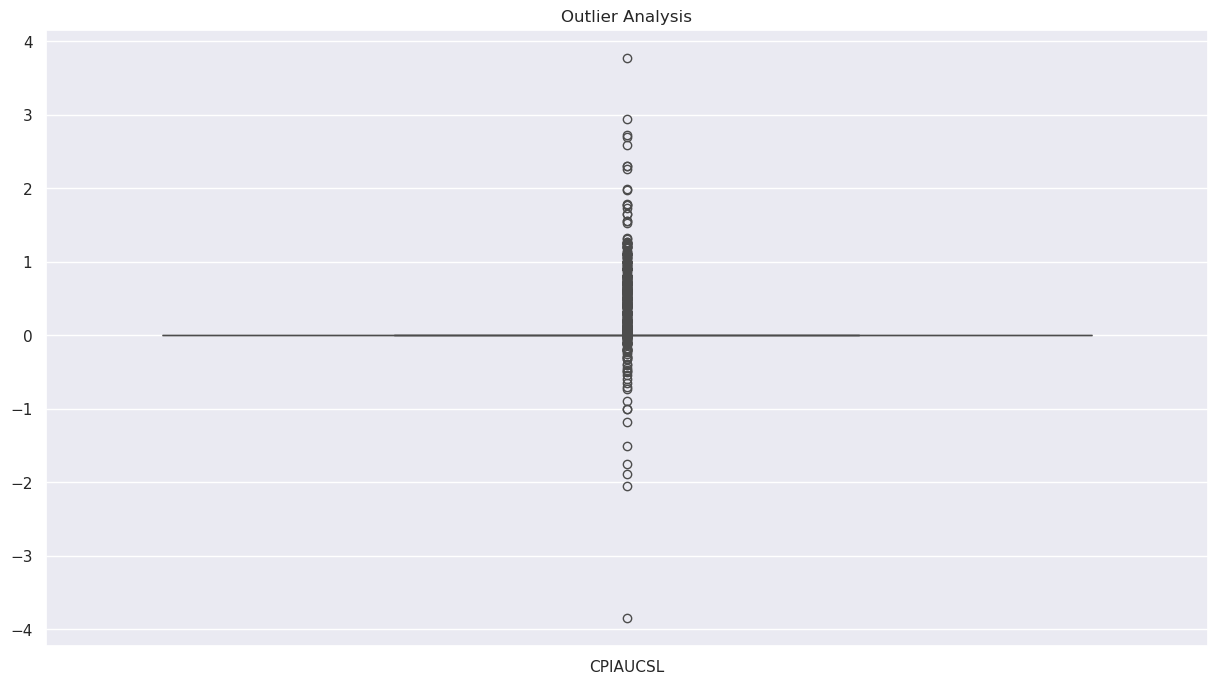

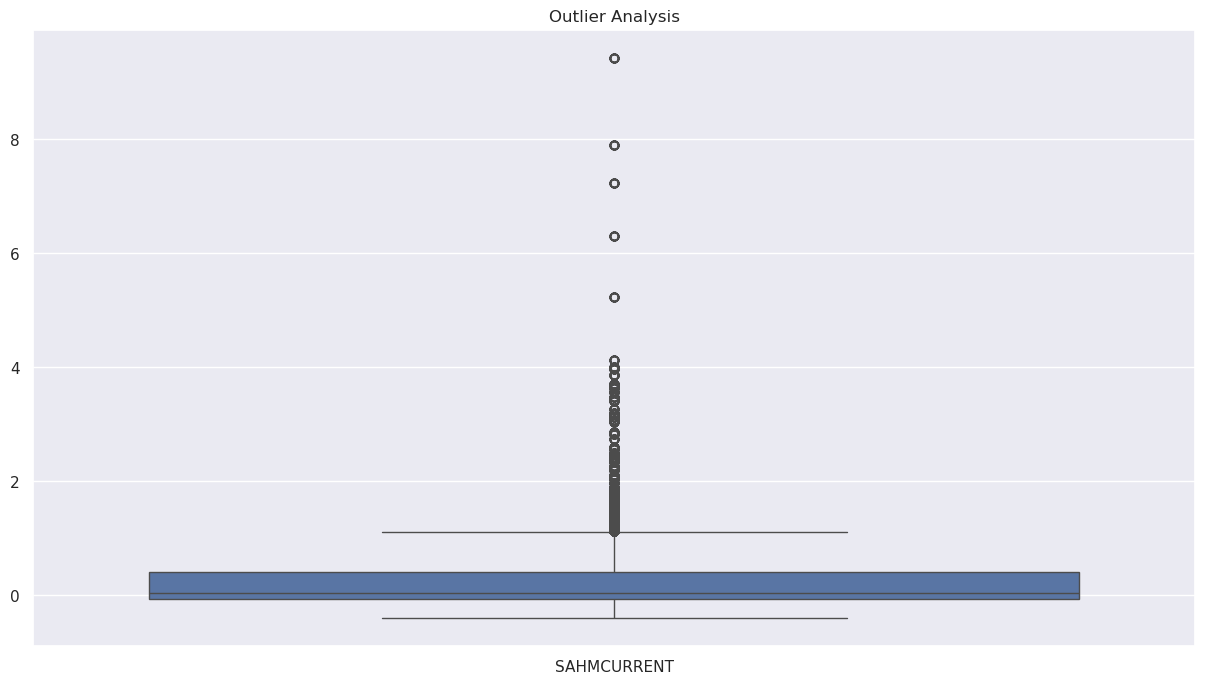

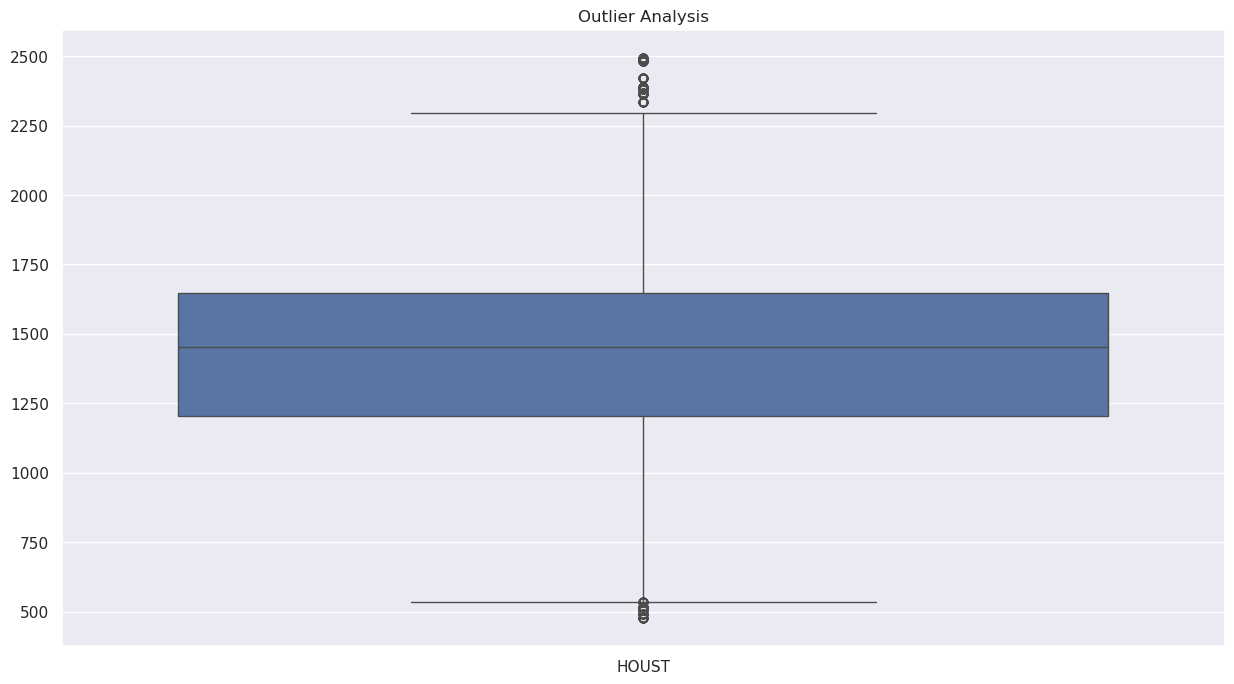

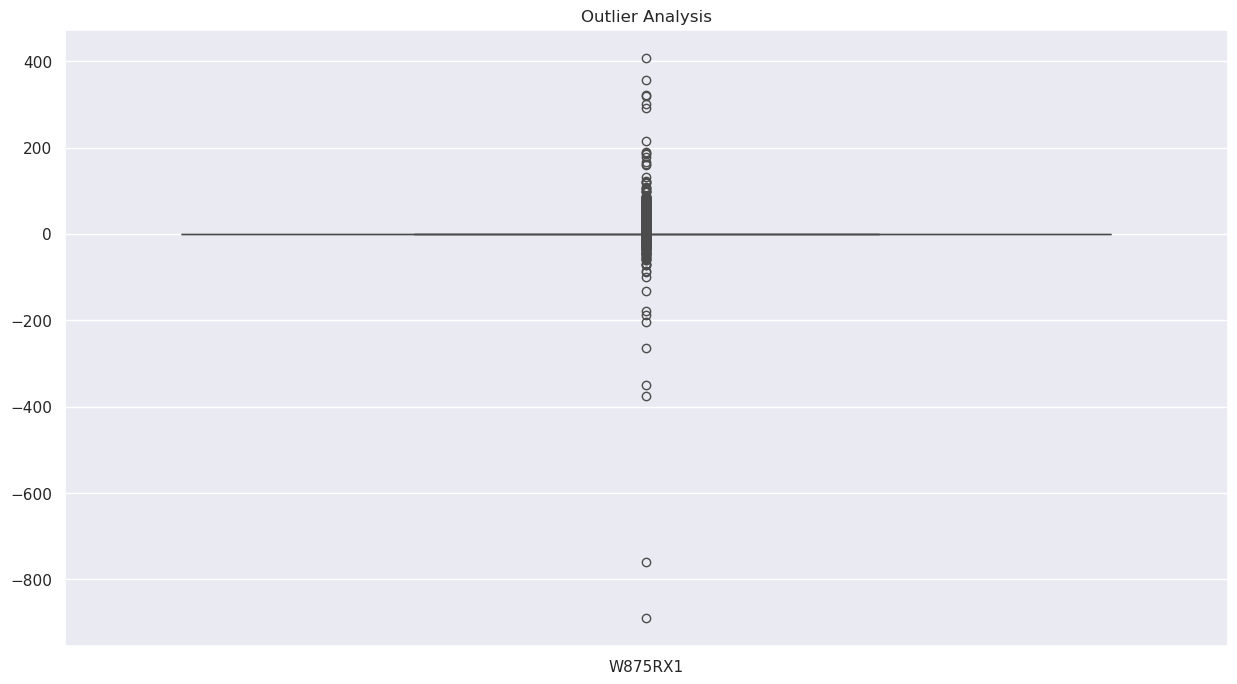

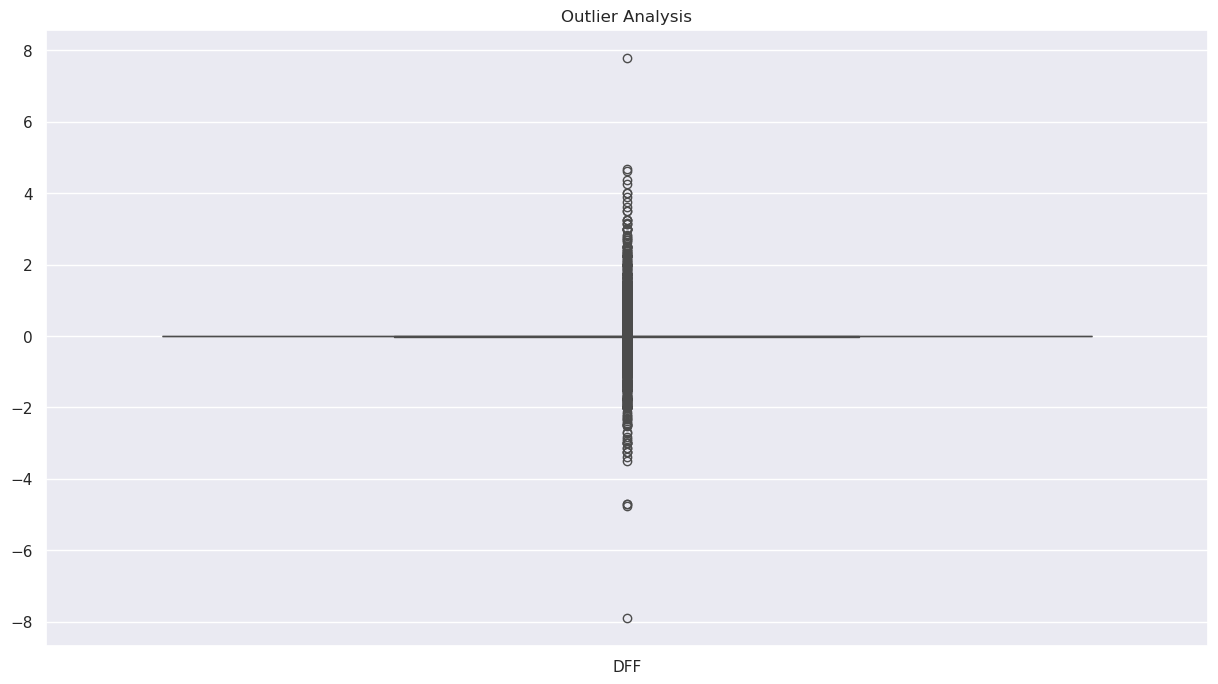

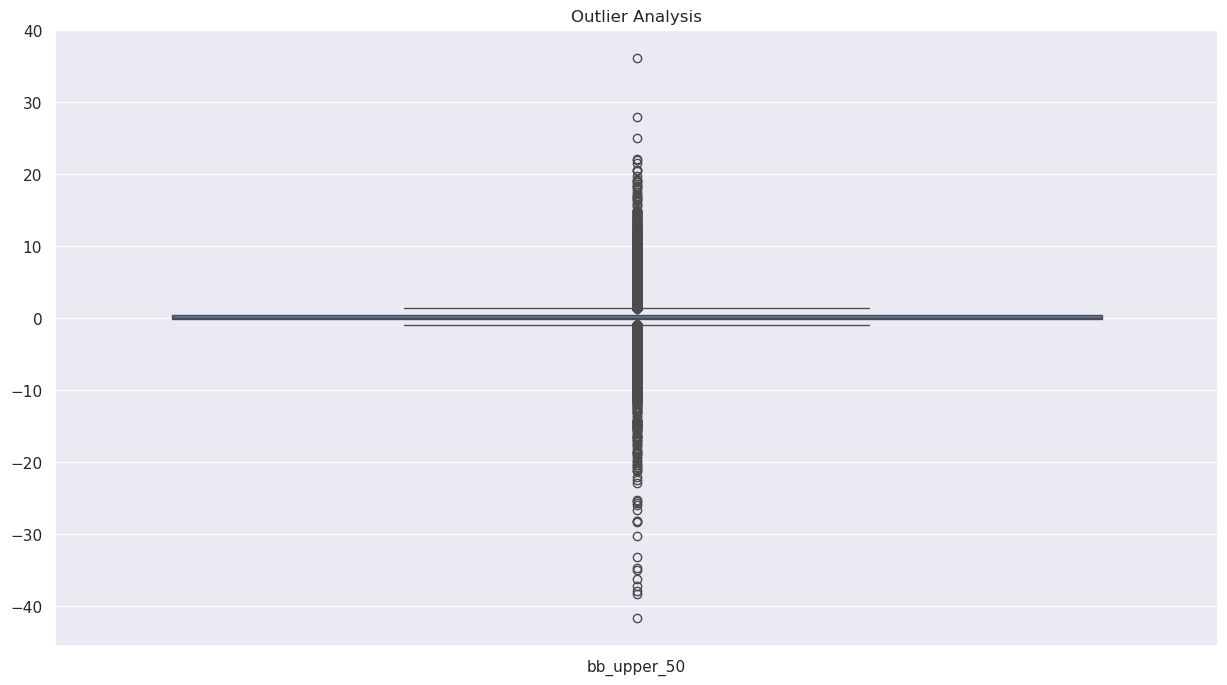

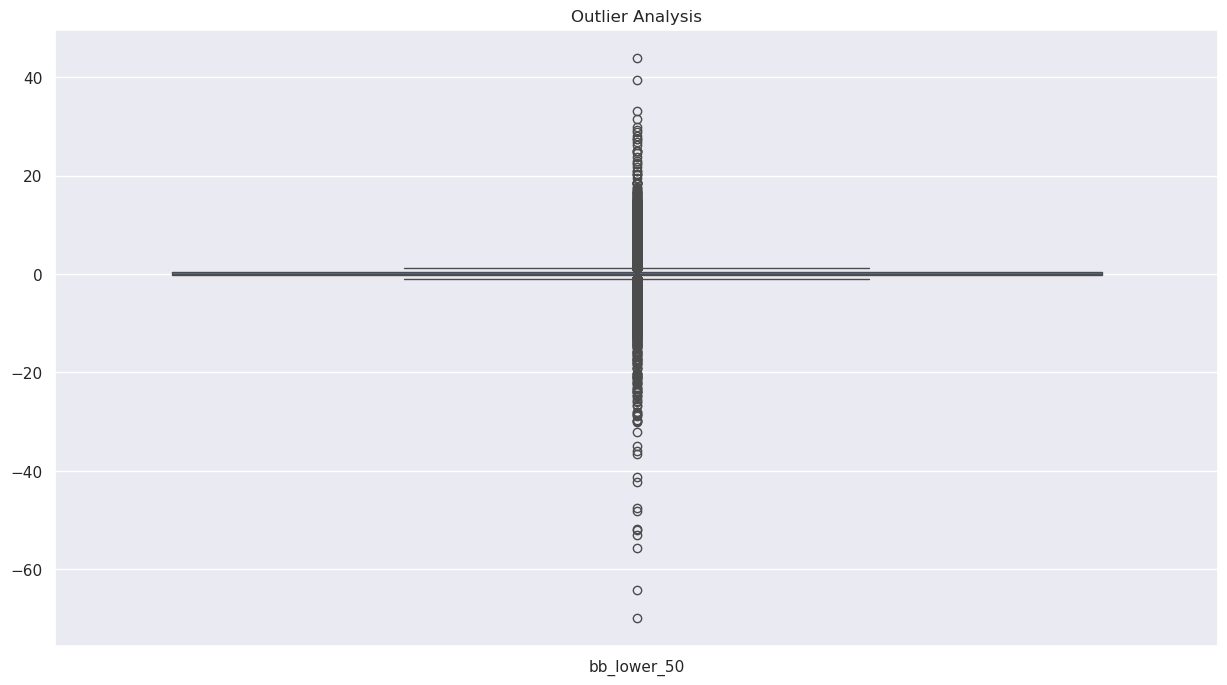

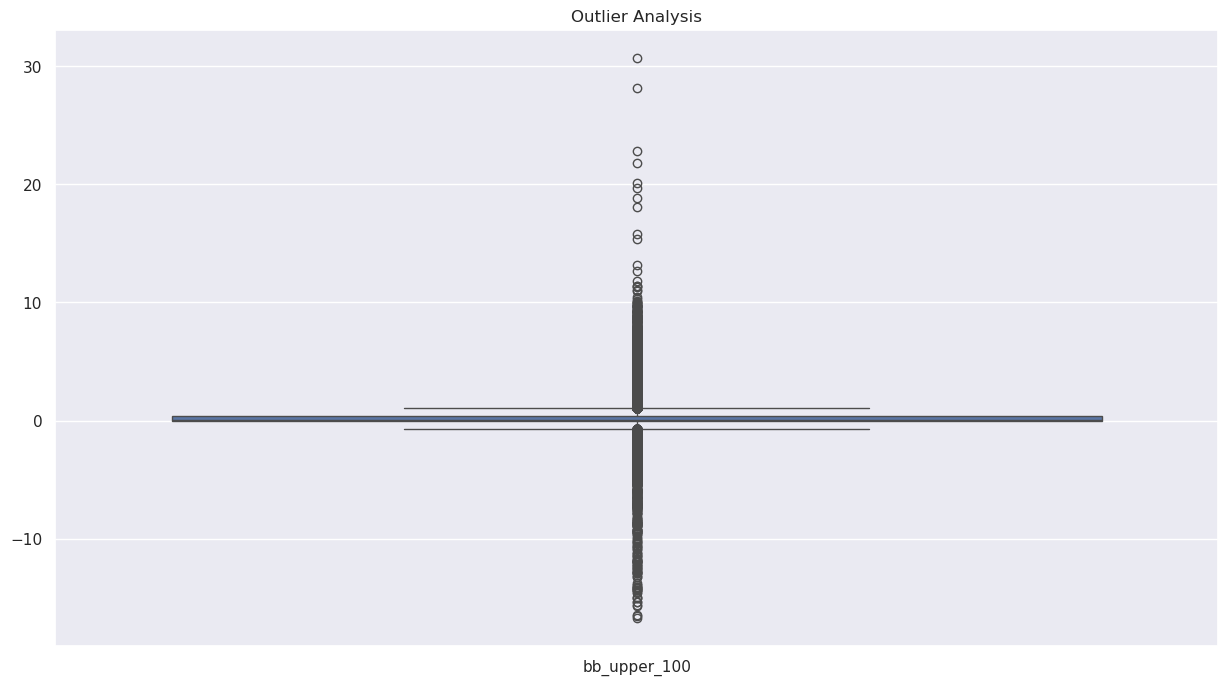

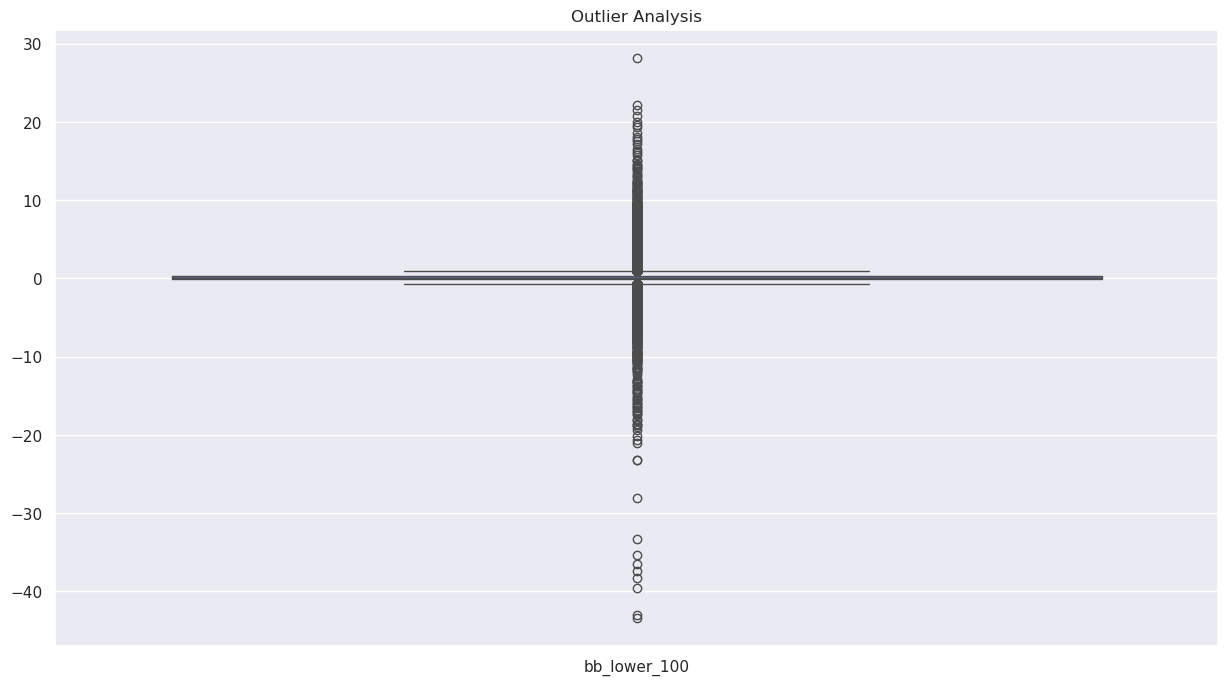

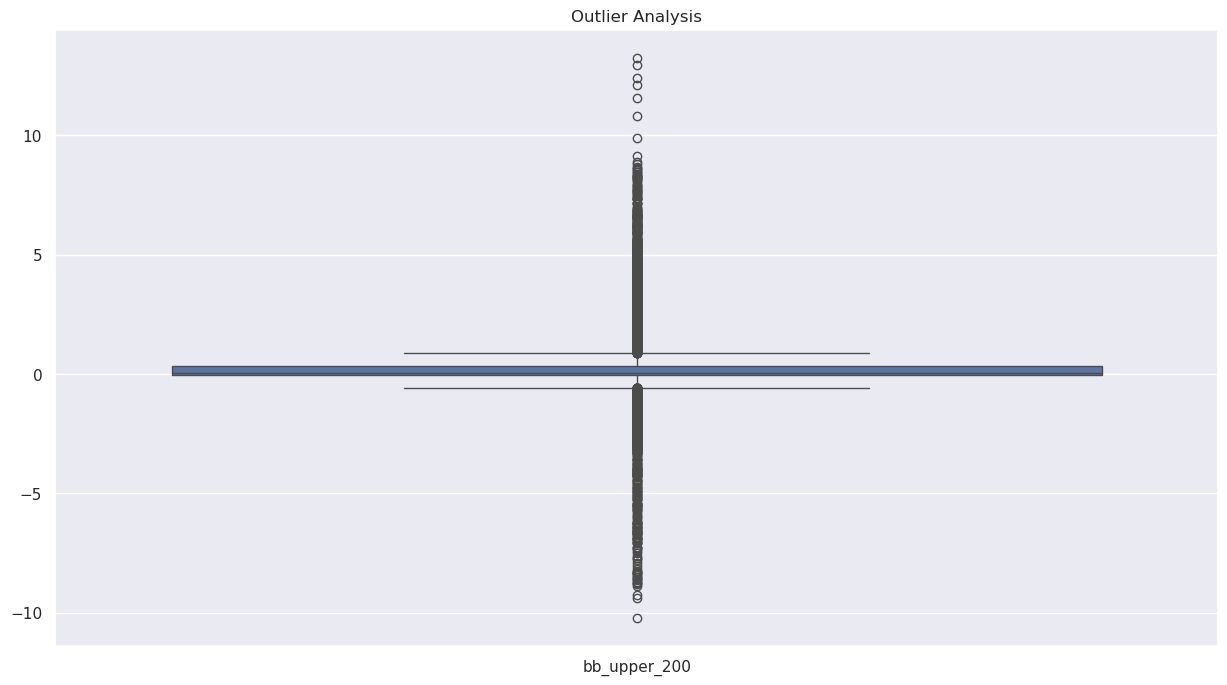

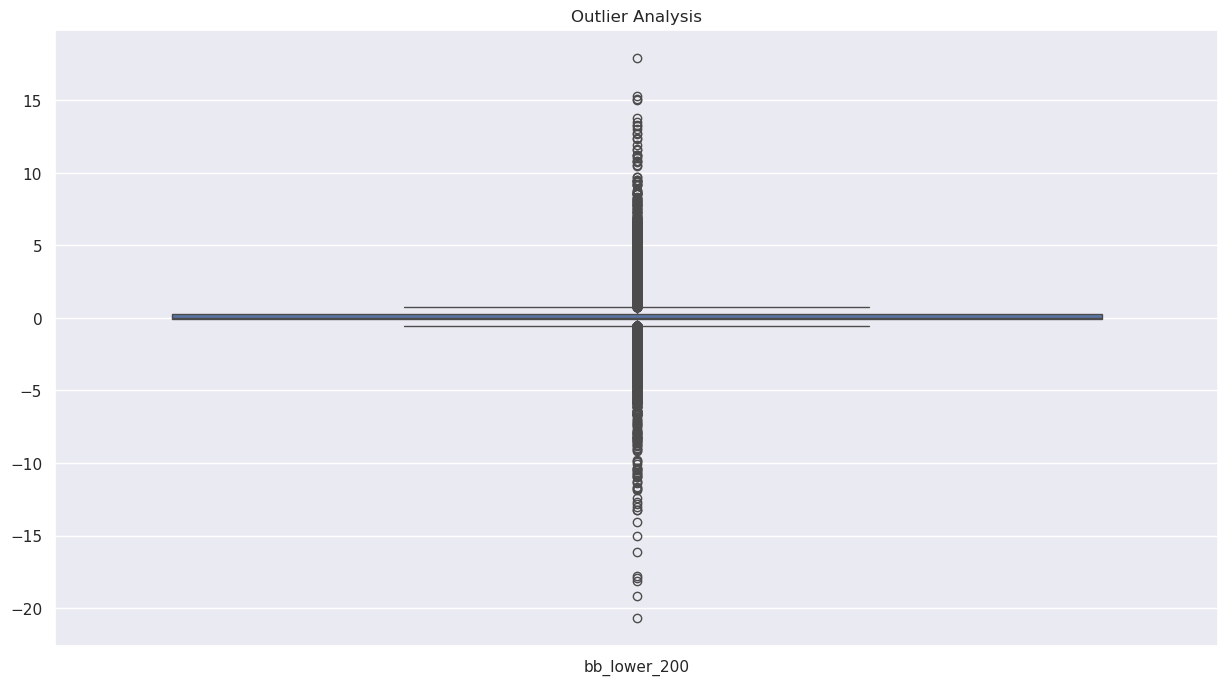

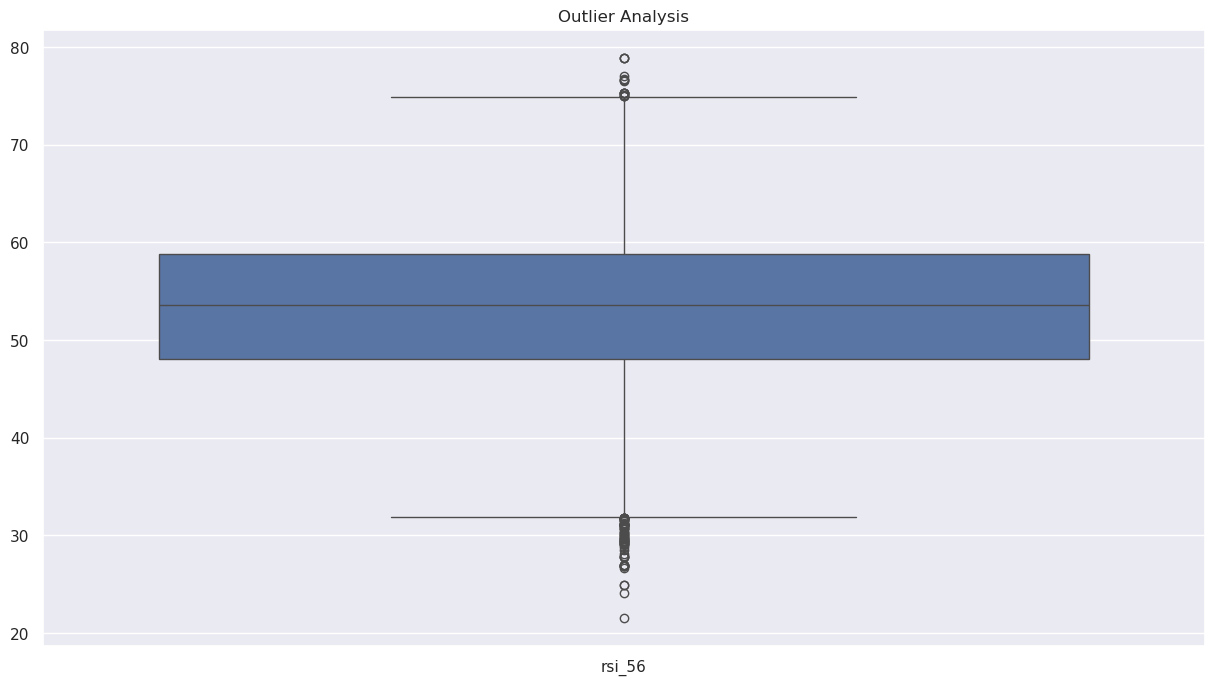

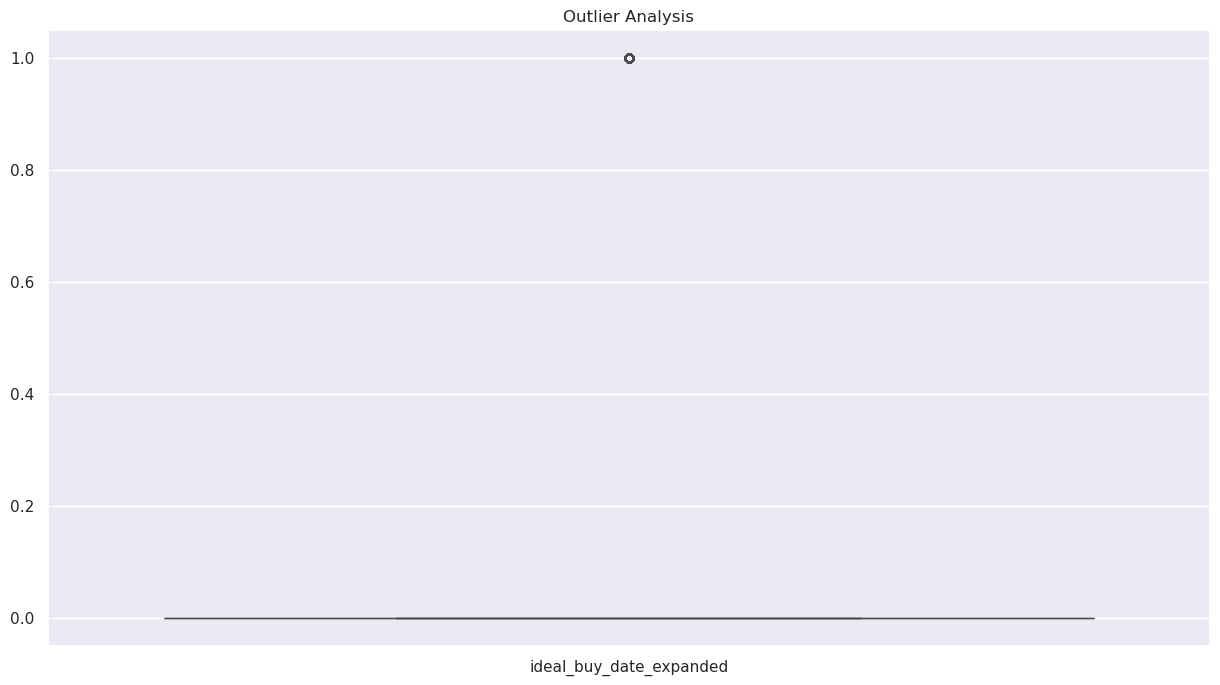

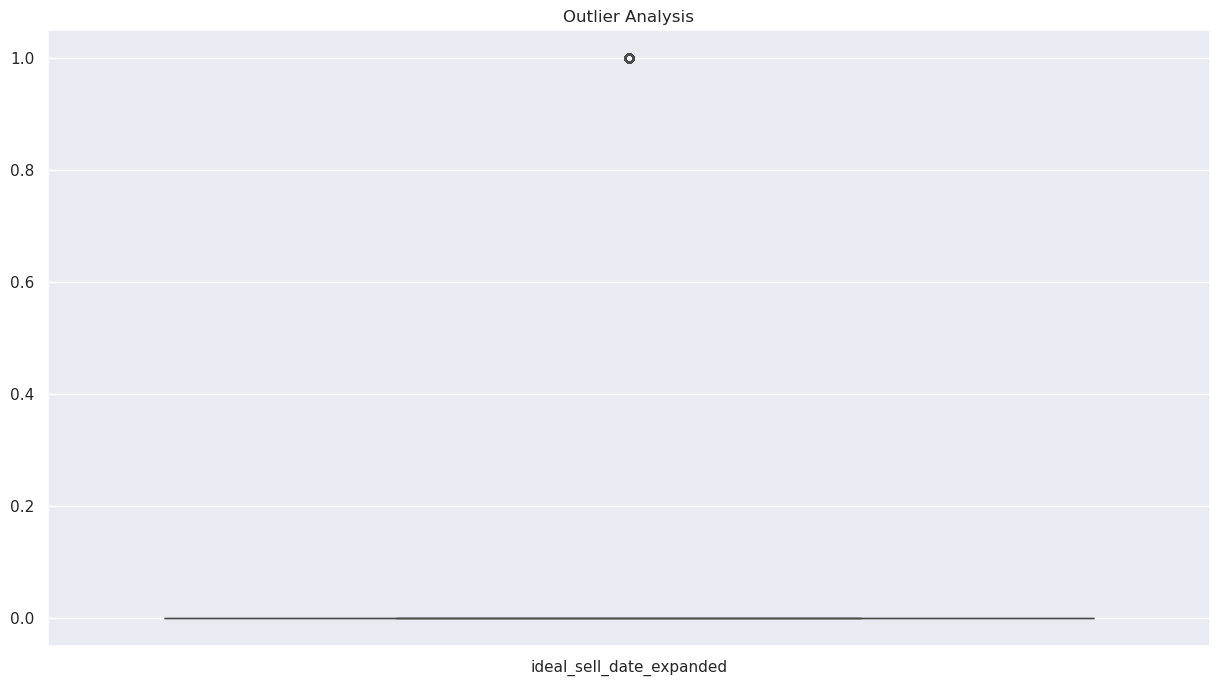

In [88]:
for col in sp_trim_xgb:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=sp_trim_xgb[[col]])
    plt.title('Outlier Analysis')
    plt.show()

Too many features for box plot. I'll filter out the outliers by using the IQR method.

In [89]:
Q1 = sp_trim_xgb.quantile(0.25)
Q3 = sp_trim_xgb.quantile(0.75)
IQR = Q3 - Q1
outliers = ((sp_trim_xgb < (Q1 - 1.5 * IQR)) | (sp_trim_xgb > (Q3 + 1.5 * IQR))).any(axis=1)


print(f"Number of outliers: {outliers.sum()} out of {len(sp_trim_xgb)} rows")


Number of outliers: 20632 out of 23726 rows


Basically every row has an IQR outlier. I will try using zscore instead.

In [90]:
z_scores = sp_trim_xgb.apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)  
print(f"Number of outliers: {outliers.sum()} out of {len(sp_trim_xgb)} rows")

Number of outliers: 4500 out of 23726 rows


RobustScaler

In [91]:

scaler = RobustScaler()
sp_trim_xgb_scaled = pd.DataFrame(scaler.fit_transform(sp_trim_xgb), columns=sp_trim_xgb.columns, index=sp_trim_xgb.index)


Rerun the model with the scaled data

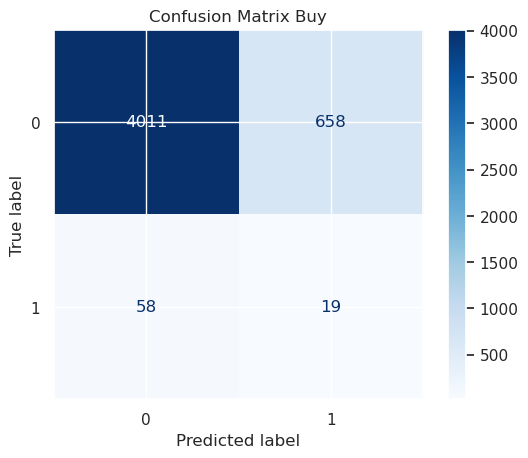

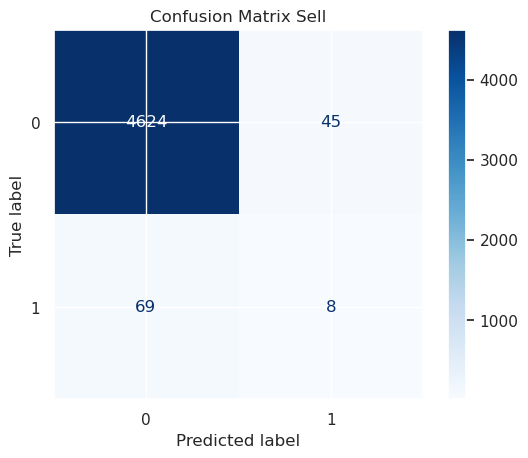

Classification Report Buy:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      4669
         1.0       0.03      0.25      0.05        77

    accuracy                           0.85      4746
   macro avg       0.51      0.55      0.48      4746
weighted avg       0.97      0.85      0.90      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.15      0.10      0.12        77

    accuracy                           0.98      4746
   macro avg       0.57      0.55      0.56      4746
weighted avg       0.97      0.98      0.97      4746



In [92]:
cmd_and_report_xgb(sp_trim_xgb_scaled)

Results worsened than unscaled data. I will try using the unscaled data with the feature importance.

Scaled:
              precision    recall  f1-score   

    1           0.03      0.25      0.05 
    1           0.00      0.00      0.00 

Precision-Recall Curve:
              precision    recall  f1-score   

    1           0.03      0.23      0.05
    1           0.19      0.14      0.16
          
Old:
              precision    recall  f1-score   

    1           0.00      0.00      0.00
    1           0.10      0.04      0.06

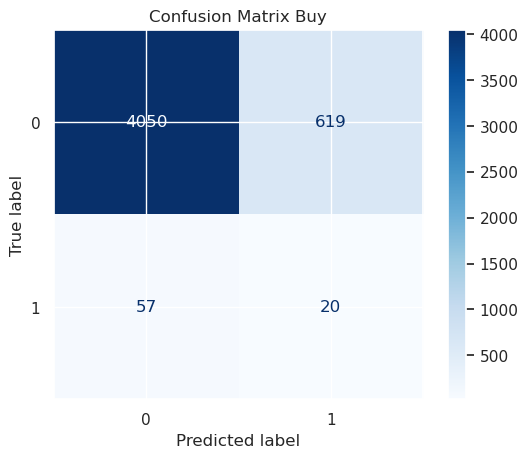

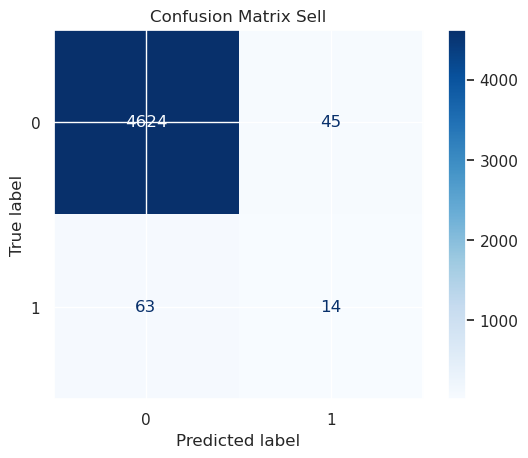

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      4669
           1       0.03      0.26      0.06        77

    accuracy                           0.86      4746
   macro avg       0.51      0.56      0.49      4746
weighted avg       0.97      0.86      0.91      4746

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.24      0.18      0.21        77

    accuracy                           0.98      4746
   macro avg       0.61      0.59      0.60      4746
weighted avg       0.97      0.98      0.98      4746



In [93]:
cmd_and_report_xgb(sp_trim_xgb)

Best results from the feature importance analysis. This is the final XGBoost model.

Scaled:
        precision    recall  f1-score   

        1       0.03      0.26     0.06  
        1       0.24      0.18     0.21   

## Logistic Regression